# CA2 PART B - Student Segmentation
***

## Importing of libraries

In [127]:
# Importing the required libraries
import pandas as pd
import numpy as np

# To remove the memory leak warning
import warnings
warnings.filterwarnings('ignore')

# Import to convert categorical features
from sklearn.preprocessing import LabelEncoder

# Import to fix the NaN values
from sklearn.impute import SimpleImputer

# Import to standarize or normalize the features for feature scaling
from sklearn.preprocessing import StandardScaler

# Import to do dimension reduction on the original dataset to know which features to drop
from sklearn.decomposition import PCA

# Import to do KMeans clustering
from sklearn.cluster import KMeans

# Import to do heirarchical clustering
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Import to do GMM clustering
from sklearn.mixture import GaussianMixture

# Import to evaluate the model 
from sklearn.metrics import silhouette_score

# Import to visualize the results
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Loading the csv as a dataset
studentPerformance_df = pd.read_csv("../CA2/Datasets/Student_Performance_dataset.csv")

## Data exploration of the student performance dataset (EDA)

In [128]:
# Show the dataset in a table
print("Showing the first 5 rows of the dataset:")
print(studentPerformance_df.head(5))

# Describe the dataset
print("\nDescribing the dataset:")
print(studentPerformance_df.describe())

# Display basic information about the dataset
print("\nBasic information of the dataset:")
print(studentPerformance_df.info())

# Check for missing values
print("\nChecking for missing values in the dataset:")
print(studentPerformance_df.isnull().sum())

# Display the available genders and their counts
gender_counts = studentPerformance_df['Gender'].value_counts()
print("\nGenders and their counts:")
print(gender_counts)

Showing the first 5 rows of the dataset:
   Student_ID  Gender  Age  English_Score  Math_Score  Science_Score
0           1  Female   18           64.0        56.0             60
1           2  Female   12           89.0        71.0             97
2           3  Female   18           69.0        69.0             80
3           4  Female   17           60.0        72.0             97
4           5    Male   13           71.0        76.0             76

Describing the dataset:
        Student_ID          Age  English_Score  Math_Score  Science_Score
count  1000.000000  1000.000000     971.000000  967.000000    1000.000000
mean    500.500000    14.970000      76.089598   76.660807      76.370000
std     288.819436     1.959832      12.767113   12.541226      12.866649
min       1.000000    12.000000      55.000000   55.000000      55.000000
25%     250.750000    13.000000      65.000000   66.000000      65.000000
50%     500.500000    15.000000      76.000000   76.000000      77.000000
75

***
From this, we can see that there is a total of 1000 entries in this dataset.

The datatypes are:
- Student_ID: int64
- Gender: object
- Age: int64
- English_Score: float64 
- Math_Score: float64
- Science_Score: int64

We can also observe that the Gender is a categorical feature which means we would need to encode it in the subsequent steps.

We also found out that there is 29 NaN values in the English_Score column and 33 NaN values in the Math_Score column which means we would need to do NaN value handling in the subsequent steps.
***

## Data cleaning of the student performance dataset

### Checking for and imputing of NaN values

In [129]:
# Check for missing values
print("Check the missing values in the dataset:")
print(studentPerformance_df.isnull().sum())

# Create SimpleImputer instances for each column
imputer_english = SimpleImputer(strategy="mean")
imputer_math = SimpleImputer(strategy="mean")

# Impute missing values in the "English_Score" and "Math_Score" columns
studentPerformance_df["English_Score"] = imputer_english.fit_transform(studentPerformance_df[["English_Score"]])
studentPerformance_df["Math_Score"] = imputer_math.fit_transform(studentPerformance_df[["Math_Score"]])

# Check for missing values
print("\nConfirm that the missing values in the dataset have been removed:")
print(studentPerformance_df.isnull().sum())

Check the missing values in the dataset:
Student_ID        0
Gender            0
Age               0
English_Score    29
Math_Score       33
Science_Score     0
dtype: int64

Confirm that the missing values in the dataset have been removed:
Student_ID       0
Gender           0
Age              0
English_Score    0
Math_Score       0
Science_Score    0
dtype: int64


***
We have succesfully removed all the NaN values in the dataset.
***

### Visualizing the data (Univariate Analysis)

#### Graph to see comparison of the number of genders

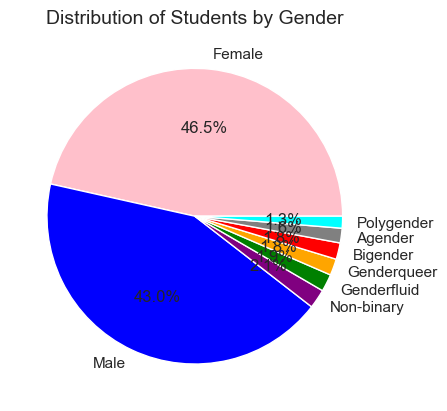

In [130]:
# Define the order of genders
gender_order = ['Female', 'Male', 'Non-binary', 'Genderfluid', 'Genderqueer', 'Bigender', 'Agender', 'Polygender']

# Count the number of occurrences of each gender
gender_counts = studentPerformance_df['Gender'].value_counts().reindex(gender_order, fill_value=0)

# Create a pie chart
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', colors=['pink', 'blue', 'purple', 'green', 'orange', 'red', 'gray', 'cyan'])

# Add title
plt.title('Distribution of Students by Gender', fontsize=14)

# Show the plot
plt.show()

***
We can see that there are more females than males by a decent amount. There are over 3.5% more females than males. There are different kind of genders present other than males and females which we will have to take into account when we do our clustering. 
***

#### Graph to see the distribution of age

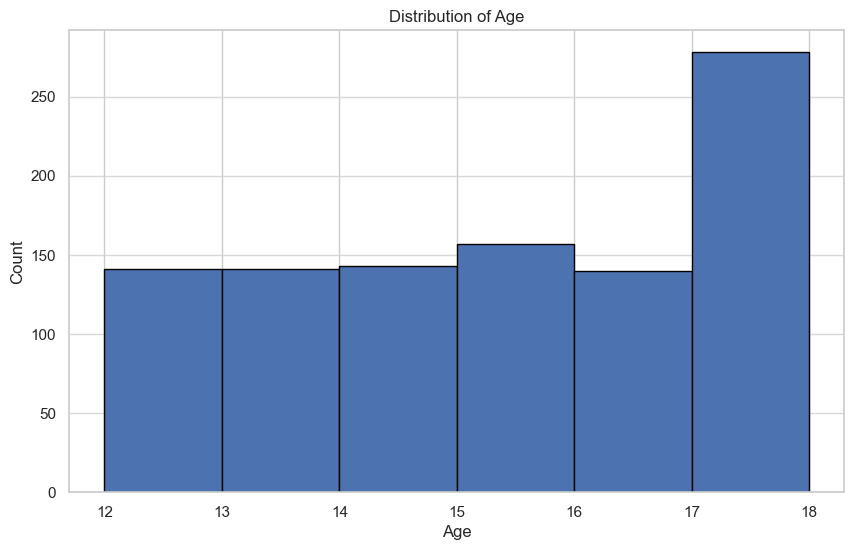

In [131]:
# Plotting the age distribution
plt.figure(figsize=(10, 6))
plt.hist(studentPerformance_df['Age'], bins=range(min(studentPerformance_df['Age']), max(studentPerformance_df['Age']) + 1), edgecolor='black')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)
plt.show()

***
The age values are distributed across a range of age 12 to 18. We can see that the age group best represented by our data is the age 18 which has the largest count.
***

#### Graph to see distribution of the 3 subject scores

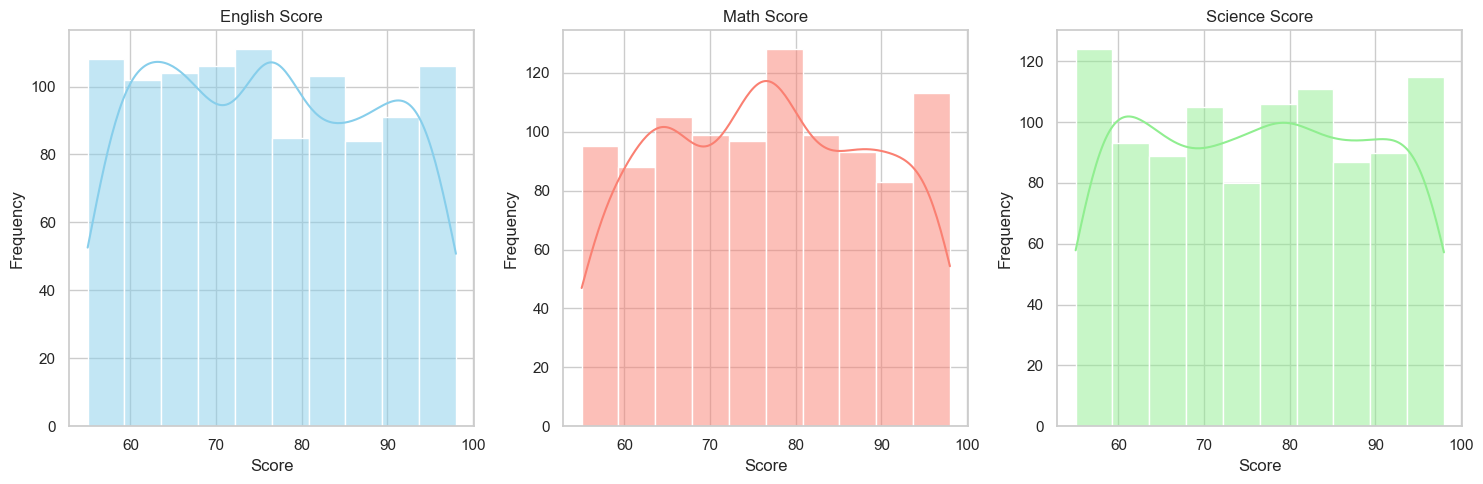

In [132]:
# Create subplots for each subject
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# English Score Histogram with Distribution Line
sns.histplot(studentPerformance_df['English_Score'], bins=10, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('English Score')
axes[0].set_xlabel('Score')
axes[0].set_ylabel('Frequency')

# Math Score Histogram with Distribution Line
sns.histplot(studentPerformance_df['Math_Score'], bins=10, kde=True, color='salmon', ax=axes[1])
axes[1].set_title('Math Score')
axes[1].set_xlabel('Score')
axes[1].set_ylabel('Frequency')

# Science Score Histogram with Distribution Line
sns.histplot(studentPerformance_df['Science_Score'], bins=10, kde=True, color='lightgreen', ax=axes[2])
axes[2].set_title('Science Score')
axes[2].set_xlabel('Score')
axes[2].set_ylabel('Frequency')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

#### Graph to compare median and range of age and scores

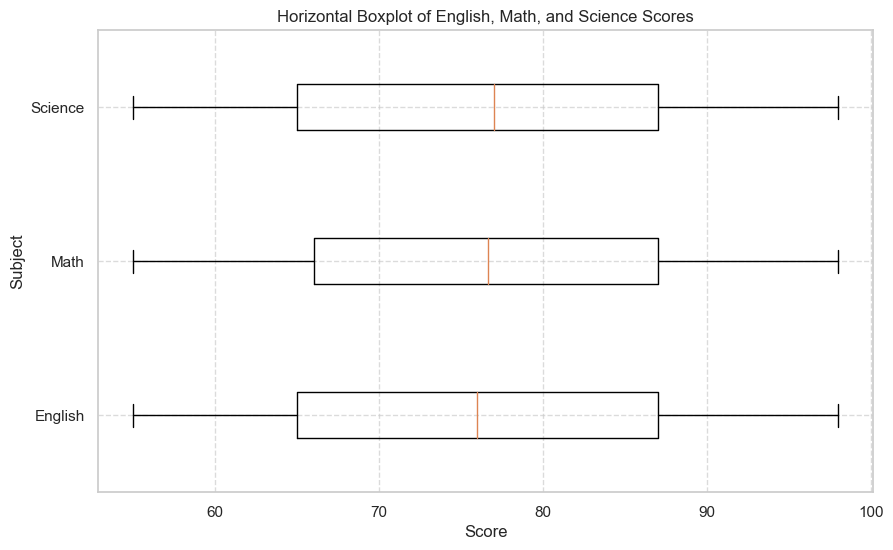

In [133]:
# Extracting the relevant columns
english_scores = studentPerformance_df['English_Score']
math_scores = studentPerformance_df['Math_Score']
science_scores = studentPerformance_df['Science_Score']

# Creating a horizontal boxplot with grid lines
plt.figure(figsize=(10, 6))
plt.boxplot([english_scores, math_scores, science_scores], labels=['English', 'Math', 'Science'], vert=False)
plt.title('Horizontal Boxplot of English, Math, and Science Scores')
plt.xlabel('Score')
plt.ylabel('Subject')

# Adding grid lines
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()


***
From this, we can see that the median of science scores is higher than the median of math and english. We can also see that the range of scores for the 3 subjects are mostly similar as seen from the whiskers. We can also see that english has a larger variance then both science and maths scores. This shows that for english scores, students have a wider range of scores compared to the other subjects.
***

### Visualizing the data (Bivariate Analysis)

#### Graph of scores against genders

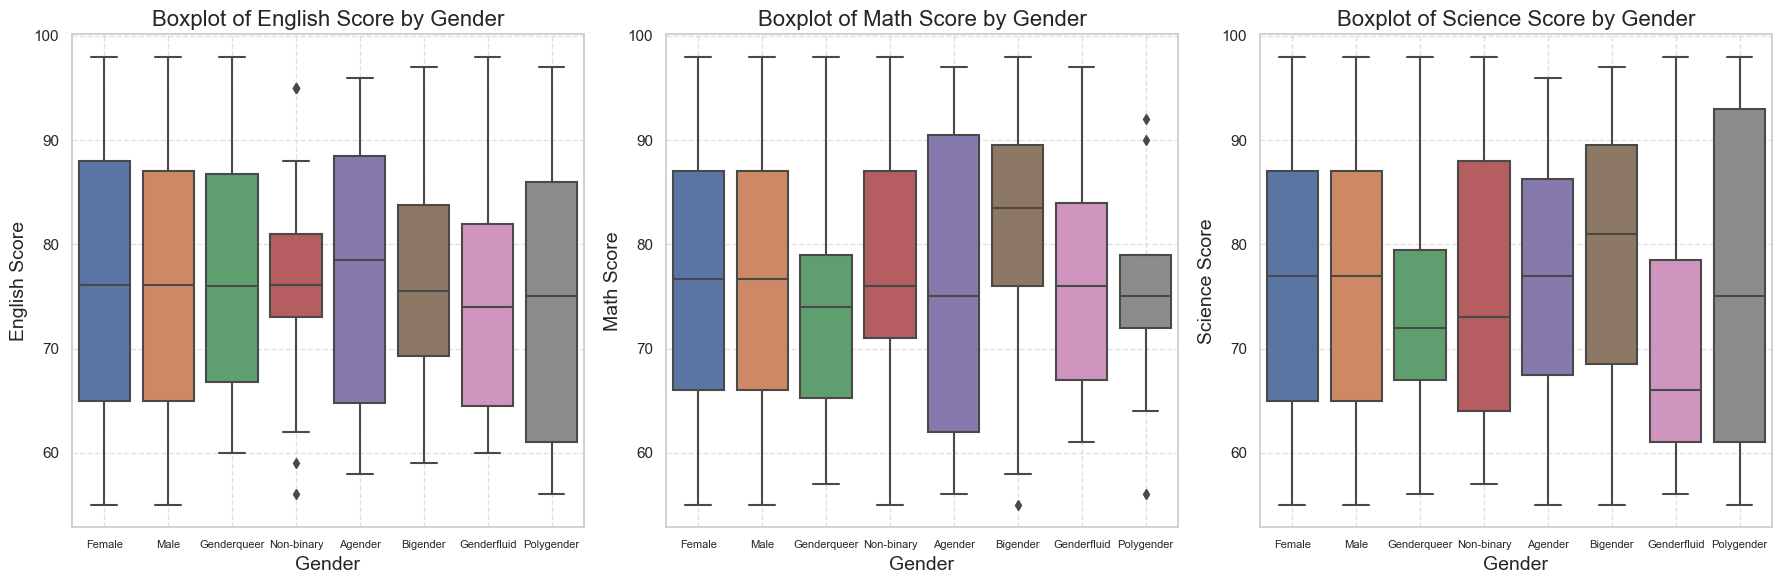

In [134]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Boxplot for English Score
sns.set(style="whitegrid")
sns.boxplot(x="Gender", y="English_Score", data=studentPerformance_df, ax=axs[0])
axs[0].set_xlabel("Gender", fontsize=14)
axs[0].set_ylabel("English Score", fontsize=14)
axs[0].set_title("Boxplot of English Score by Gender", fontsize=16)
axs[0].tick_params(axis='x', labelsize=8)
axs[0].grid(True, linestyle='--', alpha=0.6)

# Boxplot for Math Score
sns.set(style="whitegrid")
sns.boxplot(x="Gender", y="Math_Score", data=studentPerformance_df, ax=axs[1])
axs[1].set_xlabel("Gender", fontsize=14)
axs[1].set_ylabel("Math Score", fontsize=14)
axs[1].set_title("Boxplot of Math Score by Gender", fontsize=16)
axs[1].tick_params(axis='x', labelsize=8)
axs[1].grid(True, linestyle='--', alpha=0.6)

# Boxplot for Science Score
sns.set(style="whitegrid")
sns.boxplot(x="Gender", y="Science_Score", data=studentPerformance_df, ax=axs[2])
axs[2].set_xlabel("Gender", fontsize=14)
axs[2].set_ylabel("Science Score", fontsize=14)
axs[2].set_title("Boxplot of Science Score by Gender", fontsize=16)
axs[2].tick_params(axis='x', labelsize=8)
axs[2].grid(True, linestyle='--', alpha=0.6)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

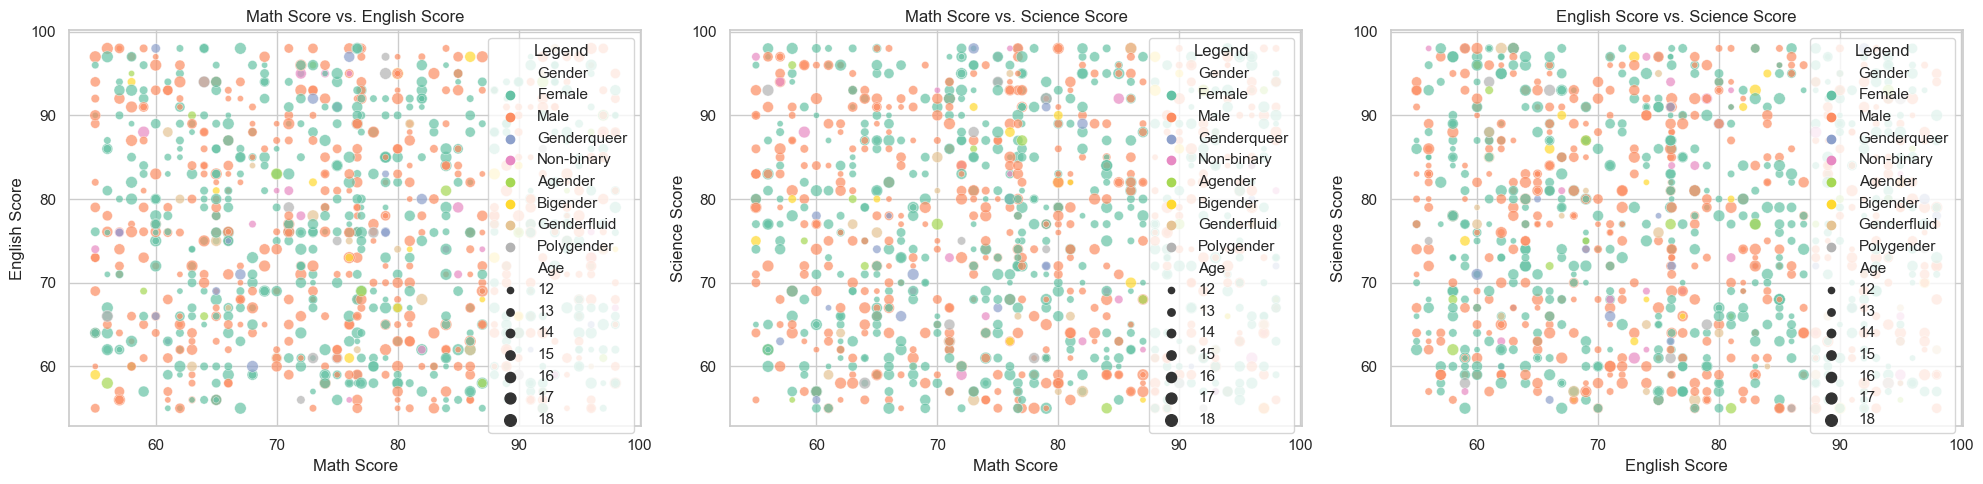

In [135]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Plot 1: English Score vs. Math Score
sns.scatterplot(
    data=studentPerformance_df,
    x="Math_Score",
    y="English_Score",
    hue="Gender",
    size="Age",
    palette="Set2",
    sizes=(20, 70),
    edgecolor='w',
    alpha=0.7,
    ax=axes[0]
)
axes[0].set_title("Math Score vs. English Score")
axes[0].set_xlabel("Math Score")
axes[0].set_ylabel("English Score")
axes[0].legend(title='Legend', loc='upper right')
axes[0].grid(True)

# Plot 2: Math Score vs. Science Score
sns.scatterplot(
    data=studentPerformance_df,
    x="Math_Score",
    y="Science_Score",
    hue="Gender",
    size="Age",
    palette="Set2",
    sizes=(20, 70),
    edgecolor='w',
    alpha=0.7,
    ax=axes[1]
)
axes[1].set_title("Math Score vs. Science Score")
axes[1].set_xlabel("Math Score")
axes[1].set_ylabel("Science Score")
axes[1].legend(title='Legend', loc='upper right')
axes[1].grid(True)

# Plot 3: English Score vs. Science Score
sns.scatterplot(
    data=studentPerformance_df,
    x="English_Score",
    y="Science_Score",
    hue="Gender",
    size="Age",
    palette="Set2",
    sizes=(20, 70),
    edgecolor='w',
    alpha=0.7,
    ax=axes[2]
)
axes[2].set_title("English Score vs. Science Score")
axes[2].set_xlabel("English Score")
axes[2].set_ylabel("Science Score")
axes[2].legend(title='Legend', loc='upper right')
axes[2].grid(True)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

## Feature engineering of the dataset

### Conversion of categorical features of the gender column by encoding

In [136]:
# Display the dataset before encoding
print("Dataset after encoding:")
print(studentPerformance_df.head(10))

# Convert categorical variables in the gender column to numerical using Label Encoding
label_encoder = LabelEncoder()
studentPerformance_df['Gender'] = label_encoder.fit_transform(studentPerformance_df['Gender'])

# Display the dataset after encoding
print("\nDataset after encoding:")
print(studentPerformance_df.head(10))

# Display the mapping of labels to genders
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("\nLabel Mapping:")
print(label_mapping)

Dataset after encoding:
   Student_ID  Gender  Age  English_Score  Math_Score  Science_Score
0           1  Female   18           64.0        56.0             60
1           2  Female   12           89.0        71.0             97
2           3  Female   18           69.0        69.0             80
3           4  Female   17           60.0        72.0             97
4           5    Male   13           71.0        76.0             76
5           6  Female   12           83.0        61.0             60
6           7  Female   12           68.0        73.0             93
7           8  Female   18           84.0        84.0             79
8           9  Female   14           94.0        71.0             94
9          10    Male   17           92.0        92.0             69

Dataset after encoding:
   Student_ID  Gender  Age  English_Score  Math_Score  Science_Score
0           1       2   18           64.0        56.0             60
1           2       2   12           89.0        71.0 

***
- One Hot Encoding
    - One Hot encoding has the disadvantage of creating a high-dimentional and sparse representation when dealing with large number of categories. Gender has many categories. Thus I will not be using use this encoding method.
- Label Encoding
    - I would be using label encoding.

After labeling the genders, the labels are
- 'Agender': 0
- 'Bigender': 1 
- 'Female': 2 
- 'Genderfluid': 3
- 'Genderqueer': 4
- 'Male': 5 
- 'Non-binary': 6 
- 'Polygender': 7
***    

### Multivariate analysis using correlataion matrix

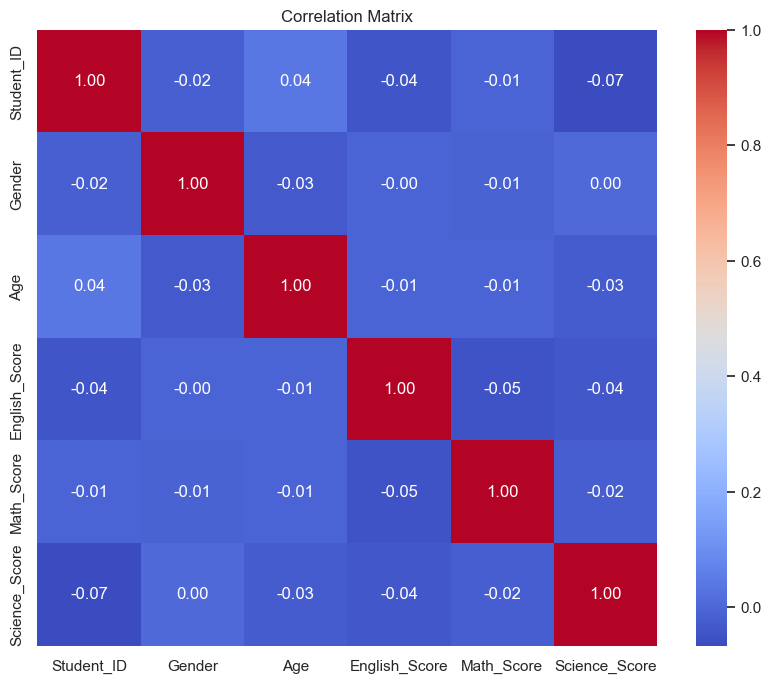

In [137]:
# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(studentPerformance_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

***
- 1 indicates a perfect positive correlation
- -1 indicates a perfect negative correlation
- 0 indicates no correlation

From this matrix, we can see that student ID does not have a correlation with scores, therefore we are going to drop the column later on.
***

### Dropping of columns

In [138]:
# Create a copy of the DataFrame without modifying the original
studentPerformanceDropped_df = studentPerformance_df.drop(columns=['Student_ID']).copy()

# Print the modified DataFrame
print(studentPerformanceDropped_df.head(10))

   Gender  Age  English_Score  Math_Score  Science_Score
0       2   18           64.0        56.0             60
1       2   12           89.0        71.0             97
2       2   18           69.0        69.0             80
3       2   17           60.0        72.0             97
4       5   13           71.0        76.0             76
5       2   12           83.0        61.0             60
6       2   12           68.0        73.0             93
7       2   18           84.0        84.0             79
8       2   14           94.0        71.0             94
9       5   17           92.0        92.0             69


### Standarizing the data

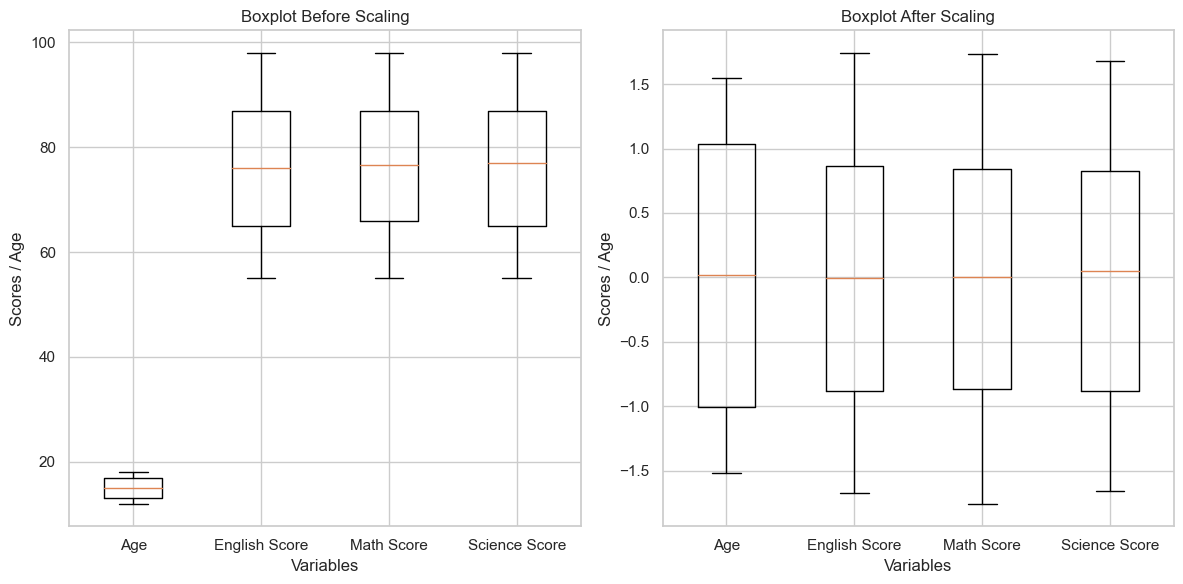

Dataset after standarizing:
   Gender       Age  English_Score  Math_Score  Science_Score
0       2  1.546825      -0.961465   -1.676173      -1.272918
1       2 -1.516194       1.026742   -0.459251       1.604172
2       2  1.546825      -0.563823   -0.621507       0.282266
3       2  1.036321      -1.279578   -0.378123       1.604172
4       5 -1.005691      -0.404767   -0.053610      -0.028771
5       2 -1.516194       0.549572   -1.270532      -1.272918
6       2 -1.516194      -0.643352   -0.296994       1.293136
7       2  1.546825       0.629100    0.595415       0.204507
8       2 -0.495188       1.424383   -0.459251       1.370895
9       5  1.036321       1.265326    1.244440      -0.573085


In [139]:
studentPerformanceScaled_df = studentPerformanceDropped_df.copy()

# Extract relevant columns before scaling
age_data_before = studentPerformanceScaled_df['Age']
english_score_data_before = studentPerformanceScaled_df['English_Score']
math_score_data_before = studentPerformanceScaled_df['Math_Score']
science_score_data_before = studentPerformanceScaled_df['Science_Score']

# Create a vertical boxplot before scaling
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.boxplot([age_data_before, english_score_data_before, math_score_data_before, science_score_data_before], labels=['Age', 'English Score', 'Math Score', 'Science Score'])
plt.title('Boxplot Before Scaling')
plt.xlabel('Variables')
plt.ylabel('Scores / Age')

# Standardize numerical features
scaler = StandardScaler()
studentPerformanceScaled_df[['Age', 'English_Score', 'Math_Score', 'Science_Score']] = scaler.fit_transform(studentPerformanceScaled_df[['Age', 'English_Score', 'Math_Score', 'Science_Score']])

# Extract relevant columns after scaling
age_data_after = studentPerformanceScaled_df['Age']
english_score_data_after = studentPerformanceScaled_df['English_Score']
math_score_data_after = studentPerformanceScaled_df['Math_Score']
science_score_data_after = studentPerformanceScaled_df['Science_Score']

# Create a vertical boxplot after scaling
plt.subplot(1, 2, 2)
plt.boxplot([age_data_after, english_score_data_after, math_score_data_after, science_score_data_after], labels=['Age', 'English Score', 'Math Score', 'Science Score'])
plt.title('Boxplot After Scaling')
plt.xlabel('Variables')
plt.ylabel('Scores / Age')

plt.tight_layout()
plt.show()

# Display the dataset after standarizing
print("Dataset after standarizing:")
print(studentPerformanceScaled_df.head(10))

***
- Z-Score Standardization (Standard Scaler)
    - This is good for preserving the original distribution and shape.
    - Gives Gaussian Distribution

- Min-Max Scaling
    - Useful when wanting to preserve the relationships between data points.
    - Cannot handle outliers.

We will be using standard scaler in this case as our data has many outliers according to EDA.
***

## KMeans clustering

### With a random k-value

In [140]:
# Create a copy of the DataFrame
kMeansRandom_studentPerformance_df = studentPerformanceDropped_df.copy()

# Perform k-means clustering with a suboptimal k
k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans.fit(kMeansRandom_studentPerformance_df)
cluster = kmeans.labels_
print(cluster)

# Each row in our dataset represents a student, therefore each row is assigned a label
studentPerformanceDropped_df["Cluster"] = cluster
studentPerformanceDropped_df.head(10)

# Checking centroid values of each cluster by averaging the features
studentPerformanceDropped_df.groupby('Cluster').mean()

[1 3 3 4 1 2 3 0 3 0 1 1 0 1 0 3 3 3 1 1 0 1 3 2 4 3 1 1 0 3 3 0 0 3 0 2 2
 4 2 4 4 1 0 4 0 4 2 3 4 0 3 2 0 3 1 0 1 2 1 0 3 2 0 1 0 0 2 2 1 2 2 3 2 2
 2 1 2 4 0 3 4 3 4 0 3 3 3 0 2 0 0 3 3 2 2 3 2 0 3 3 1 1 3 3 4 2 2 4 3 4 2
 4 1 2 4 0 3 4 0 1 2 2 3 2 3 2 2 1 1 2 1 2 4 4 4 0 1 0 1 3 2 0 2 2 0 0 3 3
 1 3 3 1 3 0 3 0 4 3 4 0 1 2 0 3 4 3 3 2 0 4 4 0 4 3 1 1 3 1 0 4 4 4 3 4 3
 2 3 0 3 2 2 1 3 3 1 3 1 3 3 3 1 1 0 1 0 4 0 4 2 1 4 4 0 1 2 4 1 3 2 3 3 1
 0 2 1 2 0 2 3 4 1 0 4 2 4 2 1 3 3 3 3 0 0 0 4 3 4 2 3 1 3 2 1 3 0 4 1 2 2
 4 1 1 1 2 3 1 4 0 0 1 3 1 2 4 0 4 4 2 4 1 3 4 3 3 3 2 1 3 4 2 2 4 1 3 4 3
 1 1 3 0 3 0 0 1 2 0 0 3 4 0 0 2 4 1 1 1 4 3 1 2 1 3 1 0 1 2 4 0 1 1 3 0 0
 0 1 3 0 2 3 4 4 4 3 3 4 3 4 3 0 1 2 1 4 1 1 2 1 4 1 3 0 0 4 3 2 3 2 0 1 3
 1 2 0 1 2 0 3 3 3 2 3 2 2 1 4 1 2 4 3 3 1 1 2 1 4 0 3 0 4 1 4 1 1 0 0 0 1
 0 3 4 4 1 4 3 2 3 1 1 4 3 2 2 4 1 0 3 4 3 4 4 3 3 4 3 0 1 3 4 2 0 0 4 3 4
 3 2 0 4 1 4 3 4 3 1 2 4 0 3 2 3 1 1 0 0 0 4 0 4 4 1 3 4 0 3 2 3 2 4 0 0 1
 4 0 4 1 1 2 4 1 4 3 0 4 

Gender        Age  English_Score  Math_Score  Science_Score
Cluster                                                               
0        3.317460  14.851852      89.065388   87.389554      77.174603
1        3.465116  15.097674      65.588547   79.599755      64.237209
2        3.430851  15.042553      86.012545   66.850783      65.340426
3        3.462222  14.848889      75.747001   65.321429      87.831111
4        3.540984  15.016393      65.252835   86.147349      87.032787

***
K-means will partition the students into 5 groups since we specified the algorithm to generate 5 clusters. The students in each cluster are similar to one another in terms of the features included in the dataset. However, this number of clusters is unoptimized and not efficient. Therefore, we will need to try find the optimal number of clusters to be used later on. We will visualize the unoptimized clusters first to see what the current clustering is.
***

### Visualizing the unoptimized clusters


#### Visualize cluster and age

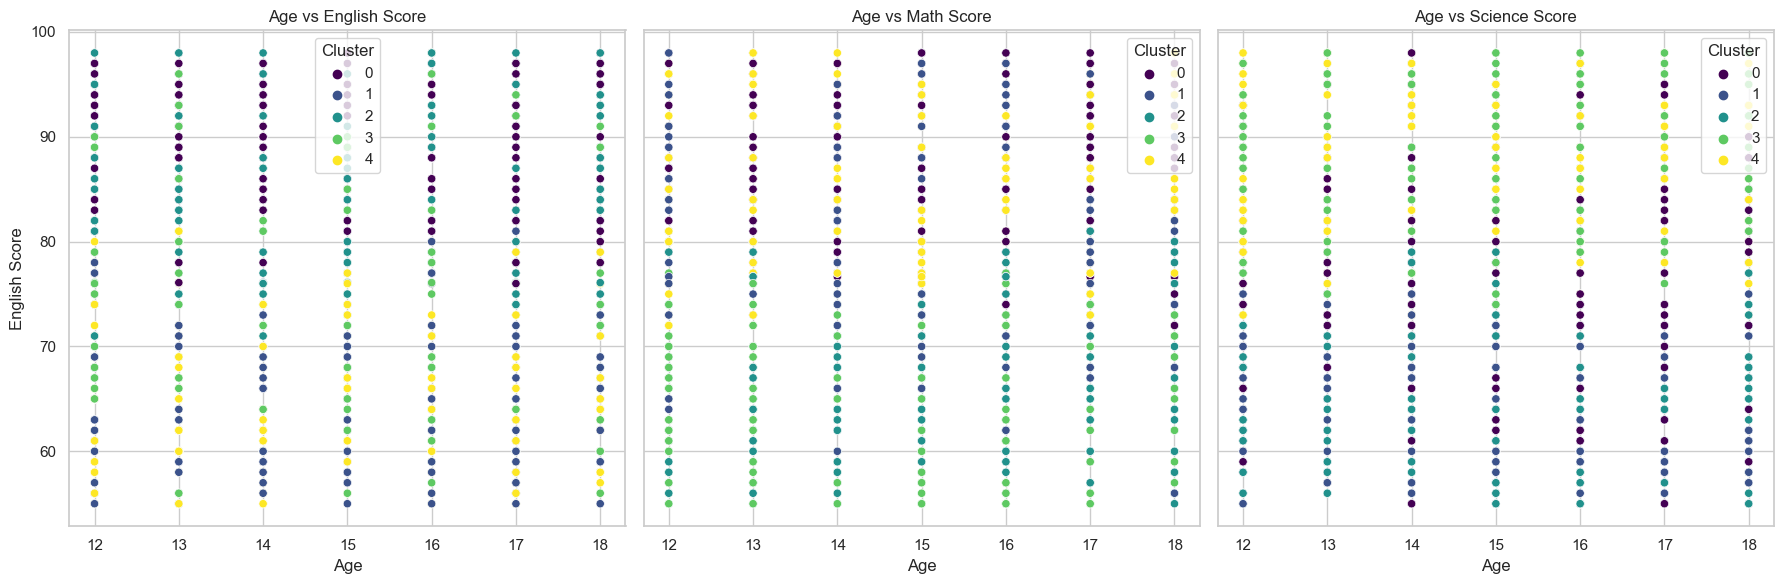

In [141]:
# Set the style of seaborn if you're using it
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Scatterplot for Age vs English Score
sns.scatterplot(x='Age', y='English_Score', hue='Cluster', data=studentPerformanceDropped_df, palette='viridis', ax=axes[0])
axes[0].set_title('Age vs English Score')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('English Score')

# Scatterplot for Age vs Math Score
sns.scatterplot(x='Age', y='Math_Score', hue='Cluster', data=studentPerformanceDropped_df, palette='viridis', ax=axes[1])
axes[1].set_title('Age vs Math Score')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Math Score')

# Scatterplot for Age vs Science Score
sns.scatterplot(x='Age', y='Science_Score', hue='Cluster', data=studentPerformanceDropped_df, palette='viridis', ax=axes[2])
axes[2].set_title('Age vs Science Score')
axes[2].set_xlabel('Age')
axes[2].set_ylabel('Science Score')

# Adjust layout
plt.tight_layout()
plt.show()

***
From the graphs above, we can see how the specific subject scores and age are clustered together.
***

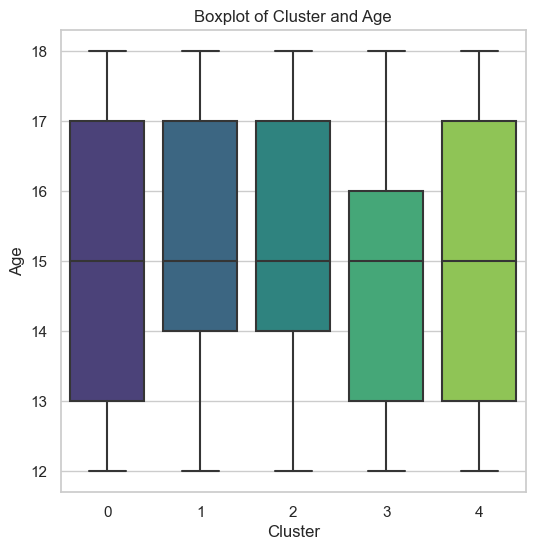

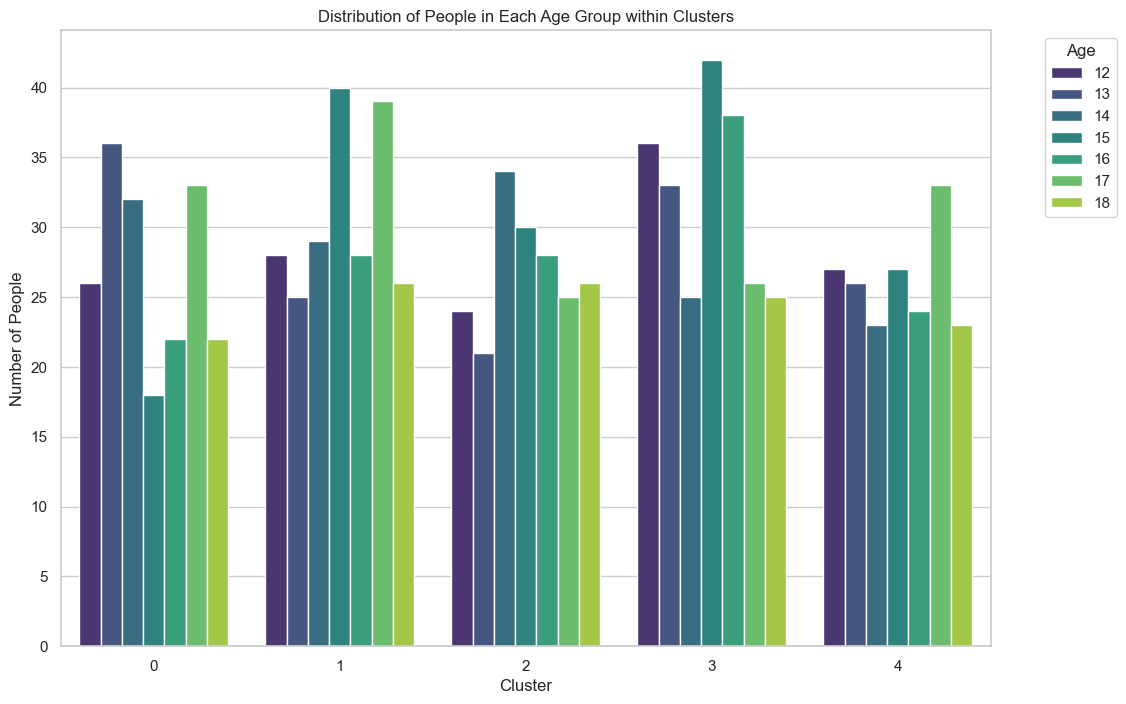

In [142]:
# Boxplot for Cluster and Age
plt.figure(figsize=(6, 6))
sns.boxplot(x='Cluster', y='Age', data=studentPerformanceDropped_df, palette='viridis')
plt.title('Boxplot of Cluster and Age')
plt.xlabel('Cluster')
plt.ylabel('Age')
plt.show()

# Count the number of people in each cluster and age
cluster_age_counts = studentPerformanceDropped_df.groupby(['Cluster', 'Age']).size().reset_index(name='Count')

# Plotting the bar graph
plt.figure(figsize=(12, 8))
sns.barplot(x='Cluster', y='Count', hue='Age', data=cluster_age_counts, palette='viridis')
plt.title('Distribution of People in Each Age Group within Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of People')
plt.legend(title='Age', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

***
From the above graph, we can see how the different ages are distributed in the 5 different clusters.
***

#### Visualize cluster and gender

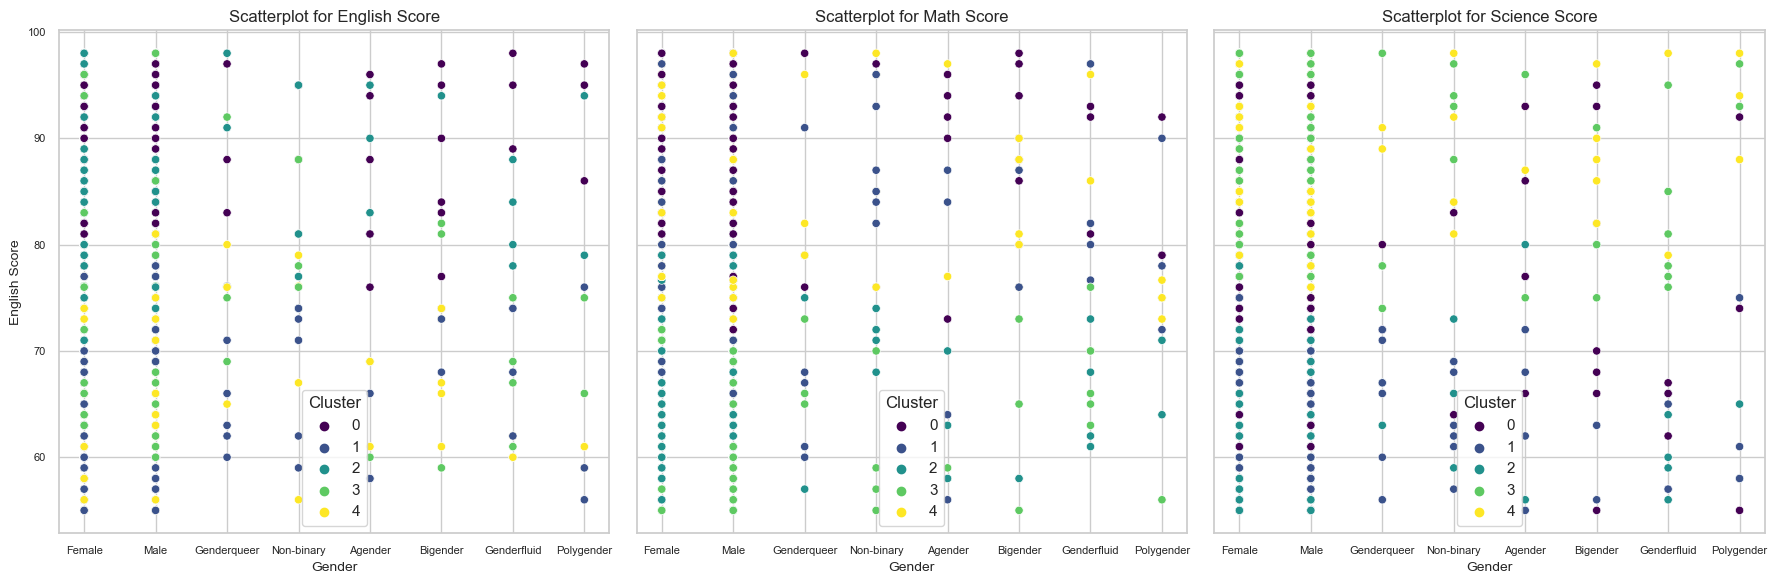

In [143]:
# Create a copy of the DataFrame
studentPerformanceGenderMap_df = studentPerformanceDropped_df.copy()

# Mapping dictionary for Gender
gender_mapping = {
    0: 'Agender', 
    1: 'Bigender', 
    2: 'Female', 
    3: 'Genderfluid', 
    4: 'Genderqueer', 
    5: 'Male', 
    6: 'Non-binary', 
    7: 'Polygender'
}

# Replace numerical values with words in the 'Gender' column
studentPerformanceGenderMap_df['Gender'] = studentPerformanceDropped_df['Gender'].replace(gender_mapping)

# Set the style of seaborn if you're using it
sns.set(style="whitegrid")

# Create subplots for each score
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharey=True)

# Scatterplot for English Score vs Gender
sns.scatterplot(ax=axes[0], x='Gender', y='English_Score', hue='Cluster', data=studentPerformanceGenderMap_df, palette='viridis')
axes[0].set_title('Scatterplot for English Score', fontsize=12)
axes[0].set_xlabel('Gender', fontsize=10)
axes[0].set_ylabel('English Score', fontsize=10)
axes[0].tick_params(axis='both', which='both', labelsize=8)

# Scatterplot for Math Score vs Gender
sns.scatterplot(ax=axes[1], x='Gender', y='Math_Score', hue='Cluster', data=studentPerformanceGenderMap_df, palette='viridis')
axes[1].set_title('Scatterplot for Math Score', fontsize=12)
axes[1].set_xlabel('Gender', fontsize=10)
axes[1].set_ylabel('Math Score', fontsize=10)
axes[1].tick_params(axis='both', which='both', labelsize=8)

# Scatterplot for Science Score vs Gender
sns.scatterplot(ax=axes[2], x='Gender', y='Science_Score', hue='Cluster', data=studentPerformanceGenderMap_df, palette='viridis')
axes[2].set_title('Scatterplot for Science Score', fontsize=12)
axes[2].set_xlabel('Gender', fontsize=10)
axes[2].set_ylabel('Science Score', fontsize=10)
axes[2].tick_params(axis='both', which='both', labelsize=8)

# Adjust layout
plt.tight_layout()
plt.show()

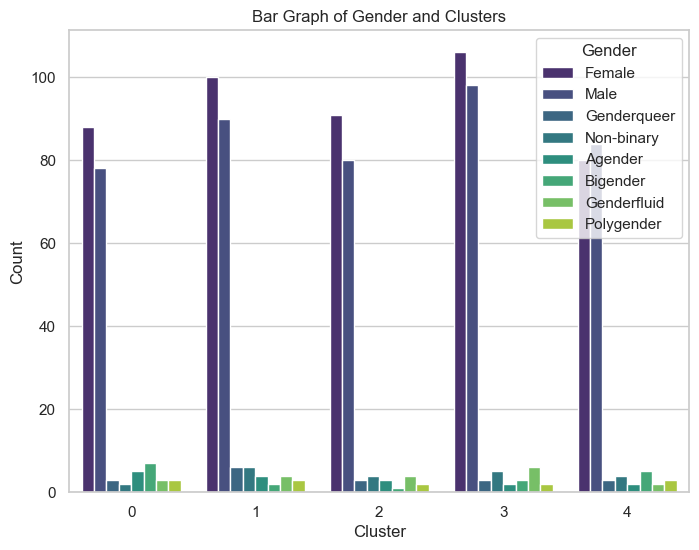

In [144]:
# Create a bar graph for gender distribution across clusters
plt.figure(figsize=(8, 6))
sns.countplot(x='Cluster', hue='Gender', data=studentPerformanceGenderMap_df, palette='viridis')
plt.title('Bar Graph of Gender and Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Gender', loc='upper right')
plt.show()

***
From the graphs above, we can see the distribution of genders across each cluster.
***

#### Visualize clusters and scores

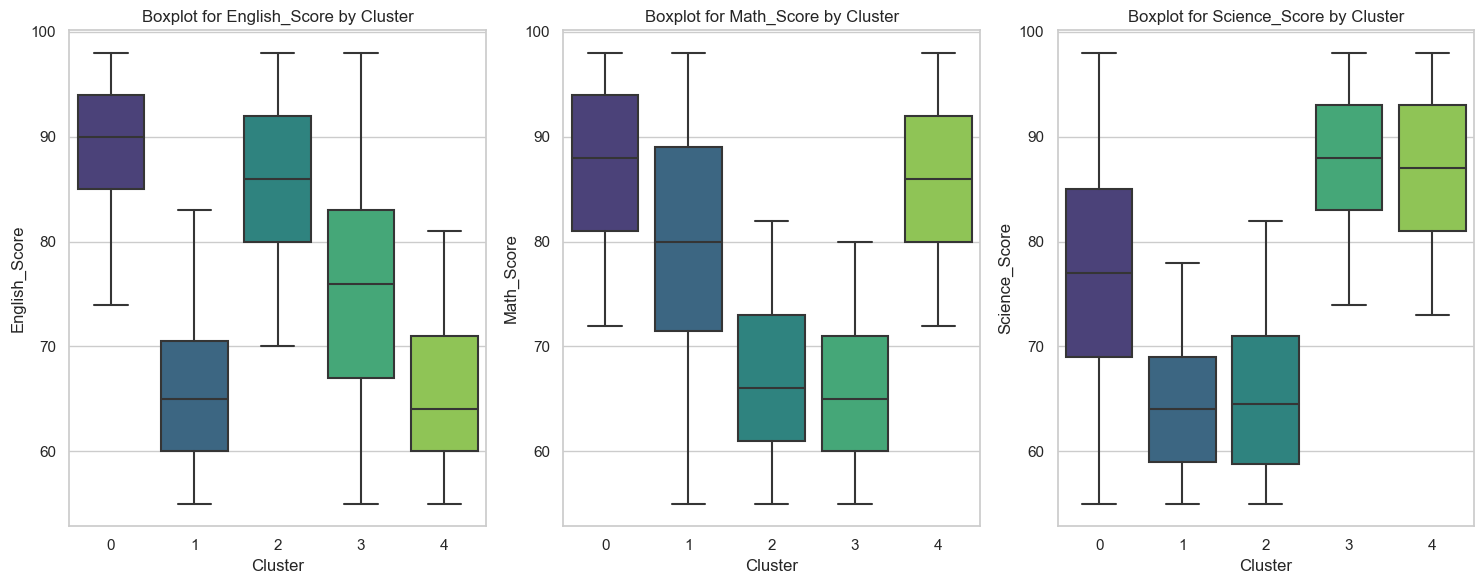

In [145]:
# Create a list of score columns
score_columns = ['English_Score', 'Math_Score', 'Science_Score']

# Create subplots for each score column
plt.figure(figsize=(15, 6))
for i, score_col in enumerate(score_columns, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='Cluster', y=score_col, data=studentPerformanceDropped_df, palette='viridis')
    plt.title(f'Boxplot for {score_col} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(score_col)

plt.tight_layout()
plt.show()

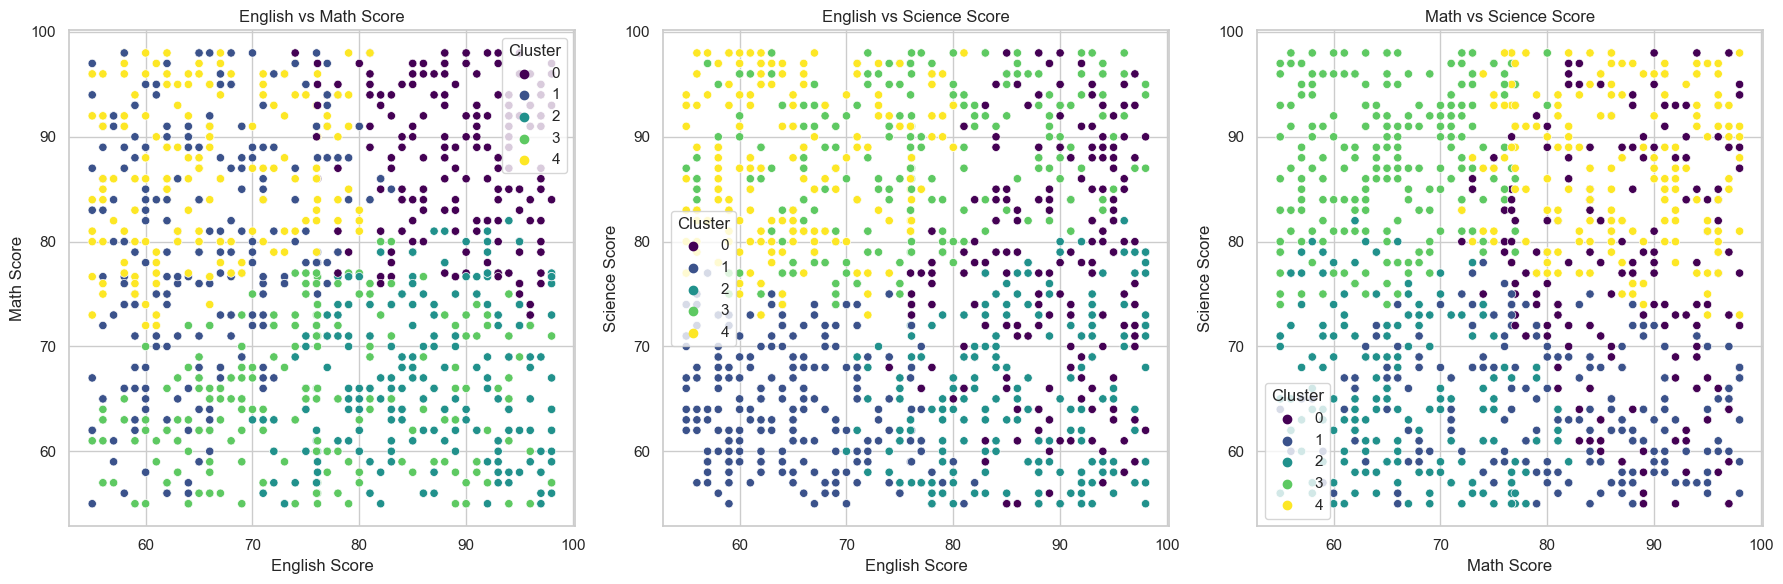

In [146]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Scatterplot for English vs Math Score
sns.scatterplot(ax=axes[0], x='English_Score', y='Math_Score', hue='Cluster', data=studentPerformanceDropped_df, palette='viridis')
axes[0].set_title('English vs Math Score')
axes[0].set_xlabel('English Score')
axes[0].set_ylabel('Math Score')

# Scatterplot for English vs Science Score
sns.scatterplot(ax=axes[1], x='English_Score', y='Science_Score', hue='Cluster', data=studentPerformanceDropped_df, palette='viridis')
axes[1].set_title('English vs Science Score')
axes[1].set_xlabel('English Score')
axes[1].set_ylabel('Science Score')

# Scatterplot for Math vs Science Score
sns.scatterplot(ax=axes[2], x='Math_Score', y='Science_Score', hue='Cluster', data=studentPerformanceDropped_df, palette='viridis')
axes[2].set_title('Math vs Science Score')
axes[2].set_xlabel('Math Score')
axes[2].set_ylabel('Science Score')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

***
From the graphs above, we can see how each clusters fared with their specific subject scores.
***

### Finding the optimal k-value for clustering

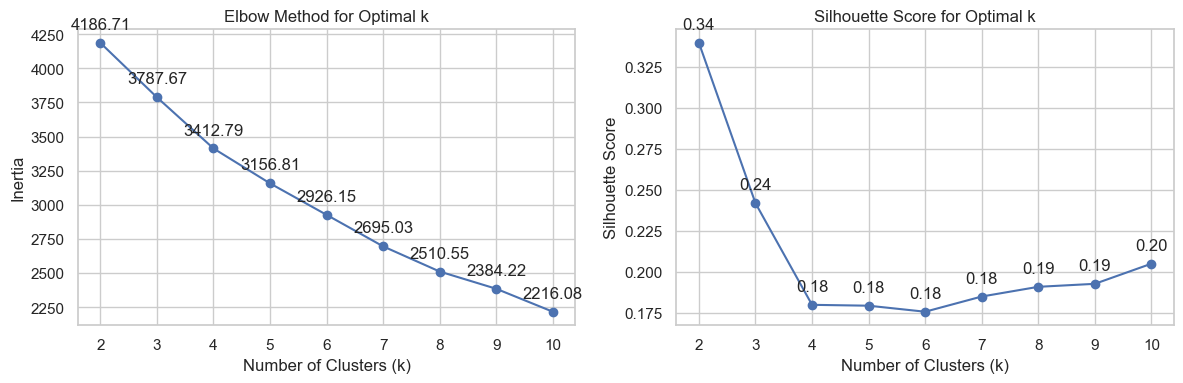

In [147]:
# Create a copy of the DataFrame
kMeans_studentPerformanceOptimal_df = studentPerformanceScaled_df.copy()

# Elbow Method for Inertia
inertias = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(kMeans_studentPerformanceOptimal_df)
    inertias.append(kmeans.inertia_)

# Silhouette Coefficient
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(kMeans_studentPerformanceOptimal_df)
    silhouette_avg = silhouette_score(kMeans_studentPerformanceOptimal_df, labels)
    silhouette_scores.append(silhouette_avg)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot Elbow curve
axes[0].plot(k_values, inertias, marker='o')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method for Optimal k')
# Display inertia scores
for i, txt in enumerate(inertias):
    axes[0].annotate(f"{txt:.2f}", (k_values[i], inertias[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Plot Silhouette scores
axes[1].plot(k_values, silhouette_scores, marker='o')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score for Optimal k')
# Display silhouette scores
for i, txt in enumerate(silhouette_scores):
    axes[1].annotate(f"{txt:.2f}", (k_values[i], silhouette_scores[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

***
- A better Silhouette score indicates better seperation, and generally means a better model.
- Inertia is the total square distance between data points. A lower inertia score indicates a better defined cluster, and generall a better model.

We can see from the above that The Inertia decreases with the amount of clusters, while the Silhouette coefficient increases and peaks at 2 clusters. Then it decreases towards 6 clusters, and increases again towards 10 clusters.

Even though the sillhouette score at 2 is higher that at 3, 3 has a significantly lower Inertia score. Thus I will be going with 3 clusters.
***

### Using optimal k clusters

In [148]:
# Perform k-means clustering with a suboptimal k
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans.fit(kMeans_studentPerformanceOptimal_df)
cluster = kmeans.labels_
print(cluster)

# Each row in our dataset represents a student, therefore each row is assigned a label
studentPerformanceDropped_df["Cluster"] = cluster
studentPerformanceDropped_df.head(10)

# Checking centroid values of each cluster by averaging the features
studentPerformanceDropped_df.groupby('Cluster').mean()

# Identify which group of students needs more attention
# You may want to focus on the cluster with lower average scores or specific patterns

[2 1 2 2 0 1 2 1 1 0 2 0 0 0 1 0 0 1 0 0 1 0 2 1 2 0 0 0 1 2 1 0 1 2 0 1 0
 0 1 2 0 2 1 2 1 0 0 1 0 0 0 0 0 1 2 1 0 0 0 0 2 0 0 2 1 0 0 0 2 0 0 2 0 1
 1 2 0 0 1 1 2 1 0 1 2 0 0 0 1 1 1 0 0 1 0 2 1 0 1 2 2 0 2 0 0 0 1 2 1 2 0
 2 0 1 0 1 0 2 0 1 0 1 1 1 1 1 0 0 2 0 0 0 2 0 2 0 0 1 2 2 0 0 0 0 0 1 2 1
 0 0 0 2 0 1 1 0 0 2 2 2 2 0 0 0 2 2 1 0 0 0 2 0 0 0 2 2 0 0 1 2 2 0 0 0 0
 0 0 1 2 1 0 0 1 0 2 1 2 1 0 0 0 0 1 2 0 2 1 2 0 0 0 2 0 0 1 2 0 0 1 1 0 2
 2 1 0 0 0 1 2 2 2 0 2 1 0 1 0 1 0 0 2 1 0 0 0 1 0 0 0 2 1 1 0 0 1 0 2 0 0
 0 2 0 2 0 0 0 2 0 0 2 1 2 0 0 0 0 0 1 0 2 0 0 0 1 1 1 2 0 0 1 0 0 0 2 2 0
 0 2 2 1 0 1 0 2 1 0 0 0 2 1 0 1 2 0 2 2 0 0 0 0 2 1 0 1 0 1 2 0 0 2 1 1 0
 1 0 1 0 1 0 2 0 2 2 2 0 0 2 2 1 0 1 0 0 2 2 0 0 2 0 2 1 1 0 1 0 0 1 1 2 2
 0 0 1 0 0 0 2 2 0 1 0 1 0 2 2 0 0 2 0 0 2 2 0 0 2 2 0 1 2 2 2 0 2 1 1 2 0
 0 0 2 0 0 0 0 1 0 0 2 0 0 1 1 0 2 1 2 0 2 0 0 2 1 0 1 1 2 0 2 1 0 0 0 0 2
 0 0 1 0 2 0 0 2 1 0 1 0 1 2 0 0 2 0 1 1 1 2 1 2 0 2 0 0 0 2 1 1 1 0 0 1 2
 0 0 0 0 2 0 0 2 2 2 1 2 

Gender        Age  English_Score  Math_Score  Science_Score
Cluster                                                               
0        5.060166  14.892116      76.109155   76.508080      76.481328
1        1.931727  14.791165      87.117905   74.326452      75.477912
2        1.947955  15.275093      65.846198   79.095263      76.996283

***
Each cluster represents a group of students that have similar characteristics according to these features.
Analysing each cluster:
- Cluster 0:
    - This cluster has students with an average Age of around 14 years. Their performance in English, Math, and Science is relatively balanced, with scores around the mid-70s. The Gender value is around 5, which might suggest a majority of the students being males.
- Cluster 1:
    - Students in this cluster have an average Age of 14 years. They excel in English with an average score of around 87, the highest among all clusters. However, their Math and Science scores are slightly lower than other clusters, around mid-70s. The Gender value is around 2, which might suggest a majority of the students being females.
- Cluster 2:
    - This cluster includes students with an average Age of approximately 15 years. Interestingly, their English_Score is the lowest among all clusters, around 65, but they perform better in Math and Science with scores in the high 70s. The Gender value is around 2, which might suggest a majority of the students being females.

Some characteristics we can take note of:
- Males form the majorities of cluster 0 while females form the majorities of cluster 1 and 2.
- Students in cluster 0 tend to be younger compared to those in other clusters.
- Students in cluster 2 have lower English scores and higher maths and science scores compared to those in other clusters.
- Students have mostly around the same science scores among all clusters.

We can further visualize this in the next few graphs.
***

#### Visualize clusters and age

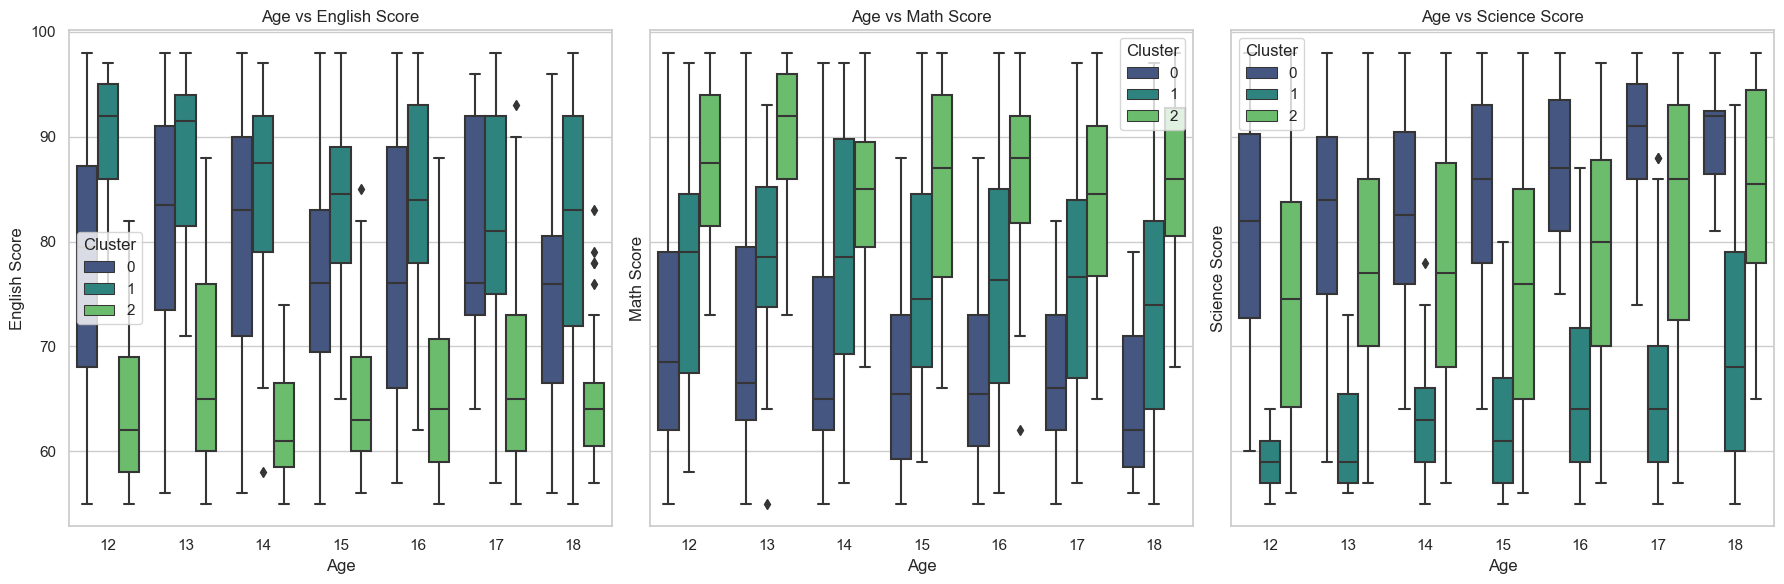

In [170]:
# Set the style of seaborn if you're using it
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Boxplot for Age vs English Score
sns.boxplot(x='Age', y='English_Score', hue='Cluster', data=studentPerformanceDropped_df, palette='viridis', ax=axes[0])
axes[0].set_title('Age vs English Score')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('English Score')

# Boxplot for Age vs Math Score
sns.boxplot(x='Age', y='Math_Score', hue='Cluster', data=studentPerformanceDropped_df, palette='viridis', ax=axes[1])
axes[1].set_title('Age vs Math Score')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Math Score')

# Boxplot for Age vs Science Score
sns.boxplot(x='Age', y='Science_Score', hue='Cluster', data=studentPerformanceDropped_df, palette='viridis', ax=axes[2])
axes[2].set_title('Age vs Science Score')
axes[2].set_xlabel('Age')
axes[2].set_ylabel('Science Score')

# Adjust layout
plt.tight_layout()
plt.show()


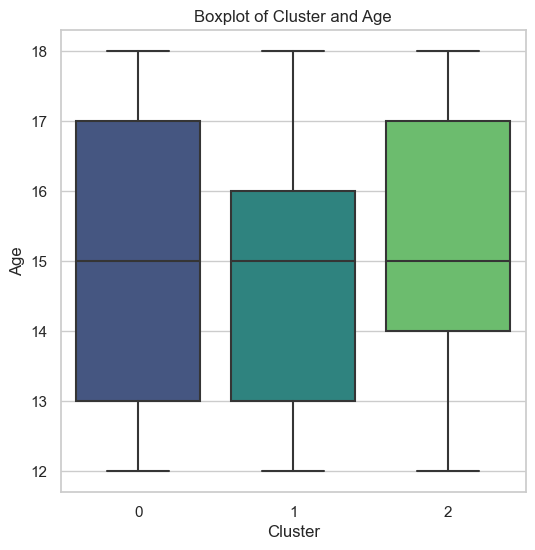

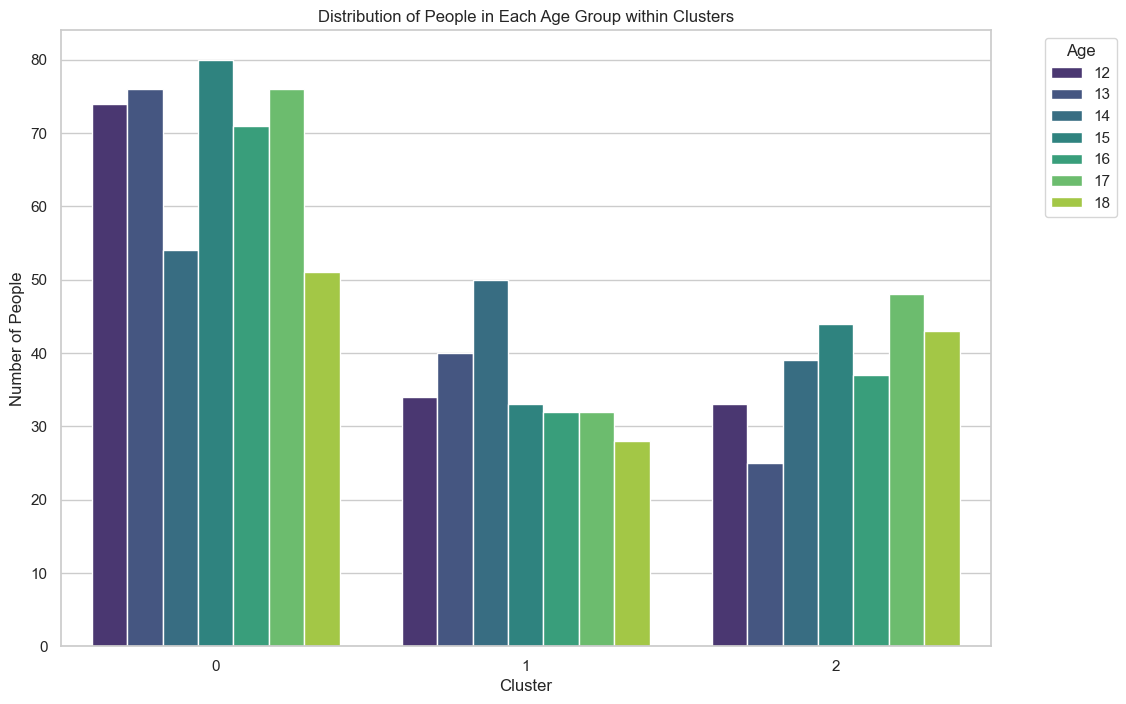

In [150]:
# Boxplot for Cluster and Age
plt.figure(figsize=(6, 6))
sns.boxplot(x='Cluster', y='Age', data=studentPerformanceDropped_df, palette='viridis')
plt.title('Boxplot of Cluster and Age')
plt.xlabel('Cluster')
plt.ylabel('Age')
plt.show()

# Count the number of people in each cluster and age
cluster_age_counts = studentPerformanceDropped_df.groupby(['Cluster', 'Age']).size().reset_index(name='Count')

# Plotting the bar graph
plt.figure(figsize=(12, 8))
sns.barplot(x='Cluster', y='Count', hue='Age', data=cluster_age_counts, palette='viridis')
plt.title('Distribution of People in Each Age Group within Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of People')
plt.legend(title='Age', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move the legend outside the plot
plt.show()

***
We can see that cluster 0 has a wider variance of ages while cluster 1 has a majority of older ages and cluster 2 having a majority of younger ages.
***

#### Visualize clusters and genders

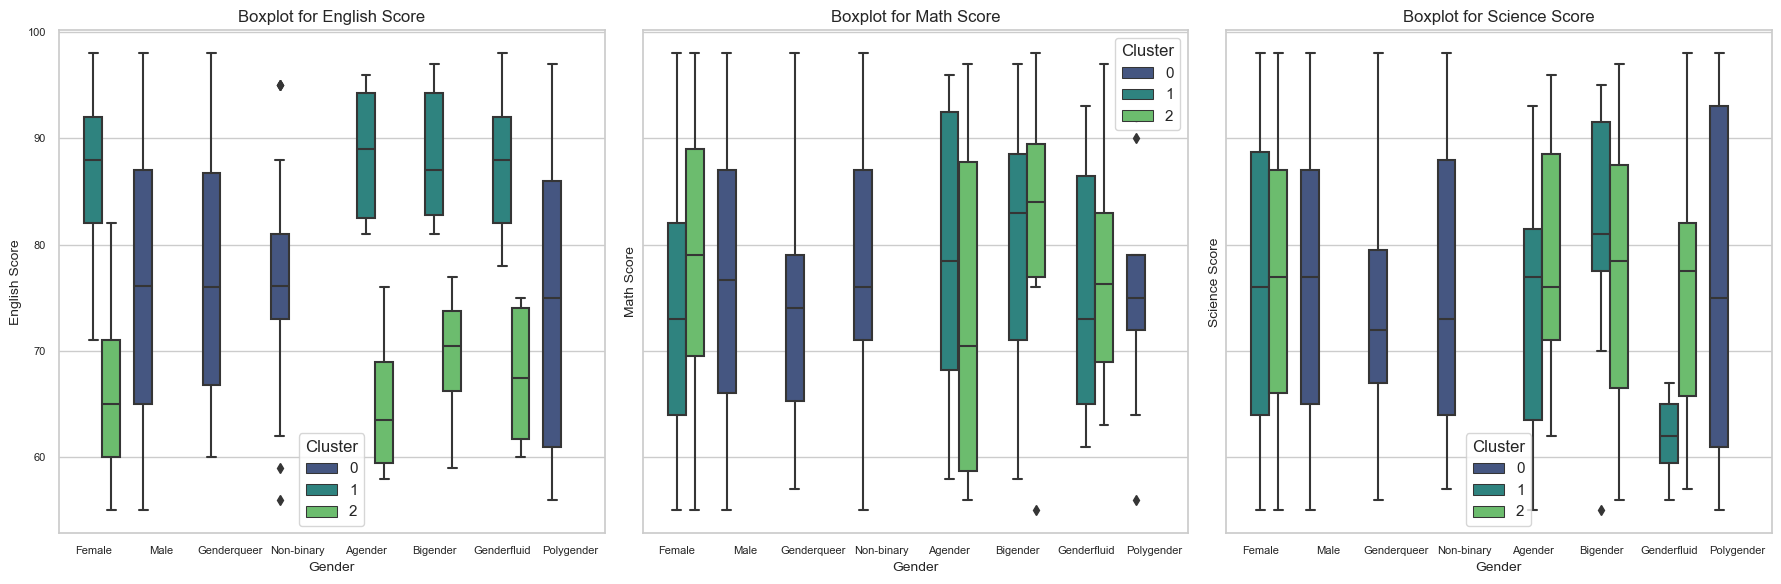

In [171]:
# Set the style of seaborn if you're using it
sns.set(style="whitegrid")

# Create subplots for each score
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharey=True)

# Boxplot for English Score vs Gender
sns.boxplot(ax=axes[0], x='Gender', y='English_Score', hue='Cluster', data=studentPerformanceGenderMap_df, palette='viridis')
axes[0].set_title('Boxplot for English Score', fontsize=12)
axes[0].set_xlabel('Gender', fontsize=10)
axes[0].set_ylabel('English Score', fontsize=10)
axes[0].tick_params(axis='both', which='both', labelsize=8)

# Boxplot for Math Score vs Gender
sns.boxplot(ax=axes[1], x='Gender', y='Math_Score', hue='Cluster', data=studentPerformanceGenderMap_df, palette='viridis')
axes[1].set_title('Boxplot for Math Score', fontsize=12)
axes[1].set_xlabel('Gender', fontsize=10)
axes[1].set_ylabel('Math Score', fontsize=10)
axes[1].tick_params(axis='both', which='both', labelsize=8)

# Boxplot for Science Score vs Gender
sns.boxplot(ax=axes[2], x='Gender', y='Science_Score', hue='Cluster', data=studentPerformanceGenderMap_df, palette='viridis')
axes[2].set_title('Boxplot for Science Score', fontsize=12)
axes[2].set_xlabel('Gender', fontsize=10)
axes[2].set_ylabel('Science Score', fontsize=10)
axes[2].tick_params(axis='both', which='both', labelsize=8)

# Adjust layout
plt.tight_layout()
plt.show()


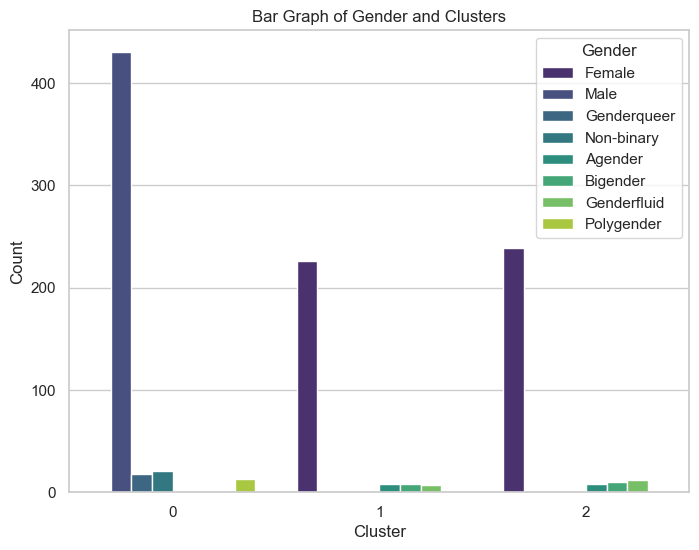

In [152]:
# Create a bar graph for gender distribution across clusters
plt.figure(figsize=(8, 6))
sns.countplot(x='Cluster', hue='Gender', data=studentPerformanceGenderMap_df, palette='viridis')
plt.title('Bar Graph of Gender and Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Gender', loc='upper right')
plt.show()

***
We can see males dominate cluster 0 while form the majority of clusters 1 and 2.
***

#### Visualize clusters and scores

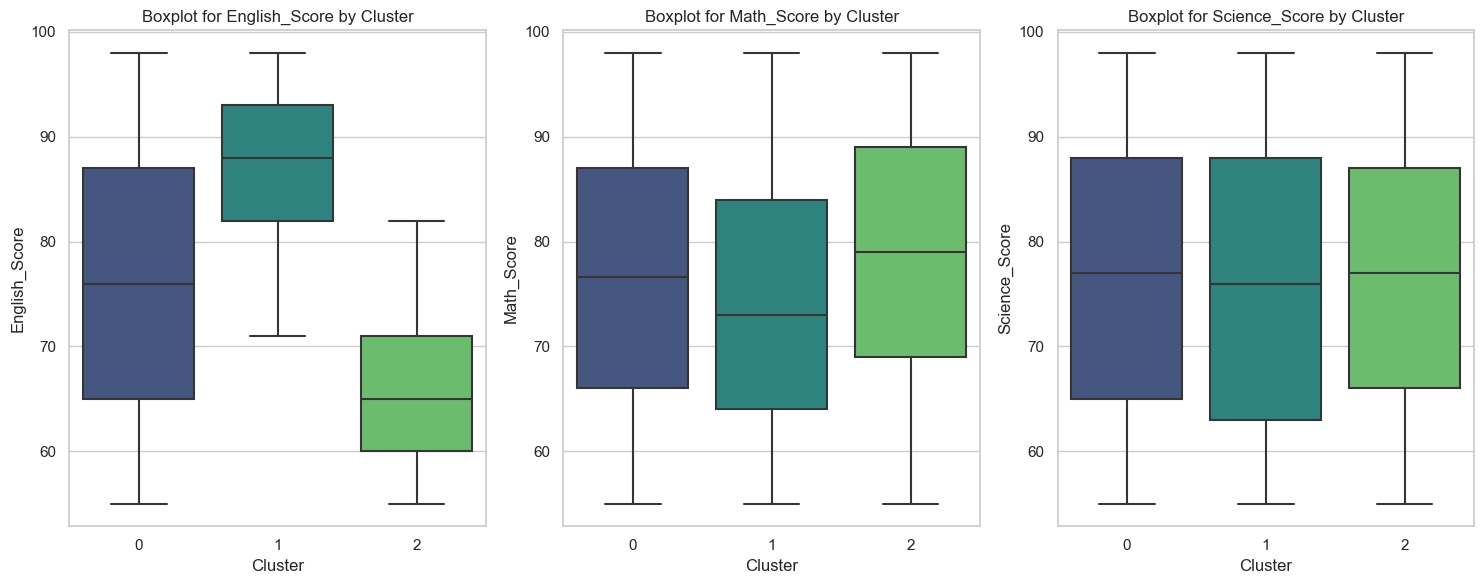

In [153]:
# Create a list of score columns
score_columns = ['English_Score', 'Math_Score', 'Science_Score']

# Create subplots for each score column
plt.figure(figsize=(15, 6))
for i, score_col in enumerate(score_columns, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='Cluster', y=score_col, data=studentPerformanceDropped_df, palette='viridis')
    plt.title(f'Boxplot for {score_col} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(score_col)

plt.tight_layout()
plt.show()

***
From boxplot, we can see that cluster 1 has more students who scored better for english but more students who scored lesser for math. We can also see that for cluster 2, the majority of the students scored badly english while scoring well for maths compared to the other clusters.
***

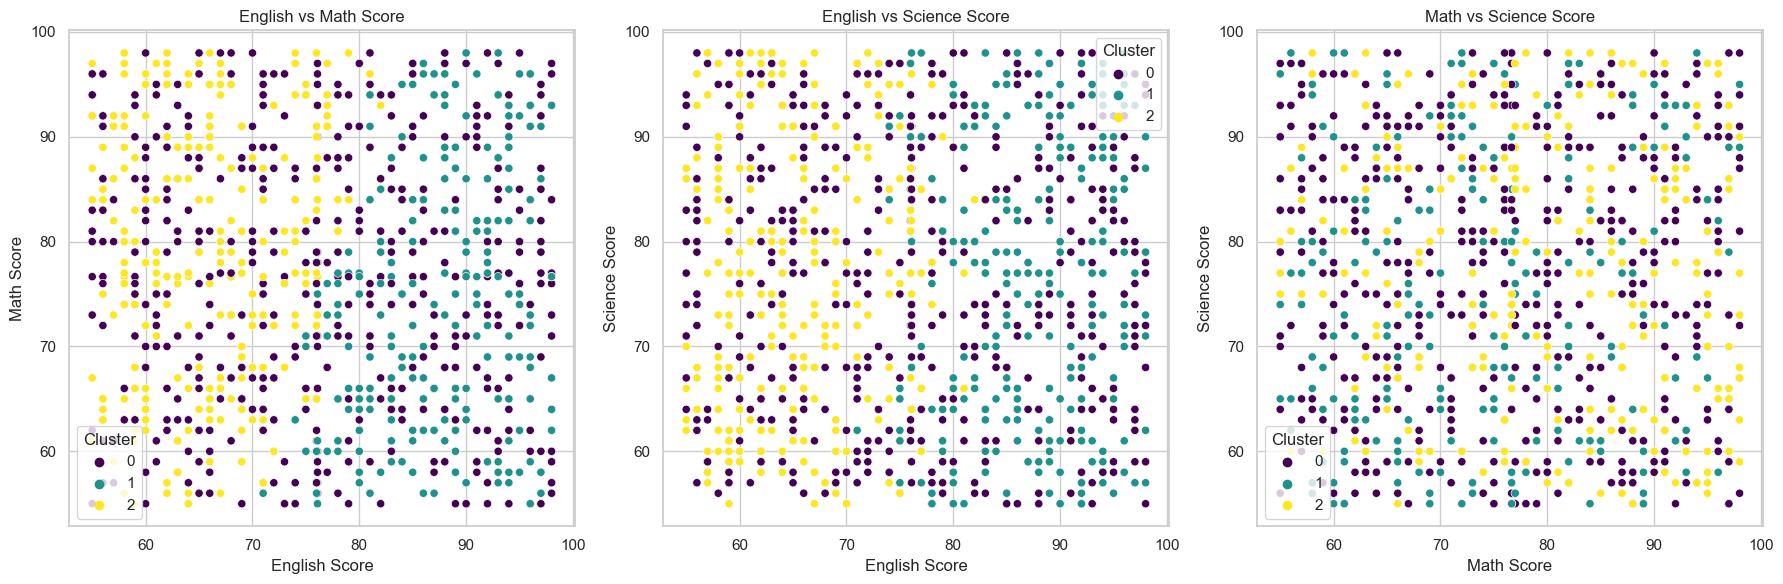

In [154]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Scatterplot for English vs Math Score
sns.scatterplot(ax=axes[0], x='English_Score', y='Math_Score', hue='Cluster', data=studentPerformanceDropped_df, palette='viridis')
axes[0].set_title('English vs Math Score')
axes[0].set_xlabel('English Score')
axes[0].set_ylabel('Math Score')

# Scatterplot for English vs Science Score
sns.scatterplot(ax=axes[1], x='English_Score', y='Science_Score', hue='Cluster', data=studentPerformanceDropped_df, palette='viridis')
axes[1].set_title('English vs Science Score')
axes[1].set_xlabel('English Score')
axes[1].set_ylabel('Science Score')

# Scatterplot for Math vs Science Score
sns.scatterplot(ax=axes[2], x='Math_Score', y='Science_Score', hue='Cluster', data=studentPerformanceDropped_df, palette='viridis')
axes[2].set_title('Math vs Science Score')
axes[2].set_xlabel('Math Score')
axes[2].set_ylabel('Science Score')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

***
We realize that it is still not the best clustering we can obtain due to the amount of dimensionality and features. Hence, we would be doing dimension reduction first before performing the k-means clustering.
***

## Dimension reduction

        PC1       PC2  Cluster
0  0.846104 -0.824114        2
1  0.250478  2.147768        1
2  0.014460 -0.249282        2
3 -1.191138  0.773789        2
4 -0.392731  0.472597        0
Explained Variance Ratio: [0.26324045 0.25817481]


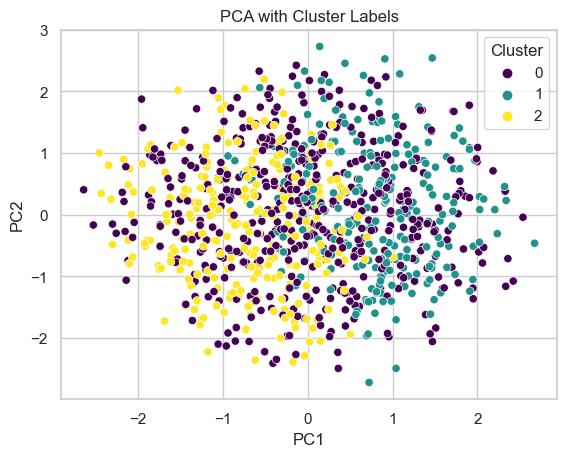

In [155]:
# Extracting the relevant features for PCA
features = ['Age', 'English_Score', 'Math_Score', 'Science_Score']

# Separating features
X = studentPerformanceDropped_df[features]

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying PCA
pca = PCA(n_components=2)  # You can choose the number of components based on your requirement
X_pca = pca.fit_transform(X_scaled)

# Creating a new DataFrame with the principal components
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])

# Adding the Cluster column from the KMeans results
pca_df['Cluster'] = studentPerformanceDropped_df['Cluster']

# Displaying the DataFrame with principal components and cluster labels
print(pca_df.head())

# Explained variance ratio
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis')
plt.title('PCA with Cluster Labels')
plt.show()

***
PC1 and PC2 are the values of the data points projected onto the first and second principal components, respectively. These components are orthogonal vectors that capture the directions of maximum variance in the data.

Cluster indicates the cluster assignment of each data point. The data points have been clustered into three groups labeled 0, 1, and 2.
The "Explained Variance Ratio" shows how much of the variance in the original data is captured by each principal component. In this case, it shows that 26.32% of the variance is explained by the first principal component and 25.82% by the second principal component.

Interpretation:

The values in PC1 and PC2 represent the transformed coordinates of the data points in a new coordinate system obtained through PCA.

The cluster column indicates which cluster each data point belongs to after clustering, likely based on their coordinates in the PCA space.

The explained variance ratios tell us how much information is retained by each principal component. In this case, around 52.14% of the total variance is explained by just the first two principal components.
***

###

        PC1       PC2  Cluster  Cluster_KMeans
0  0.846104 -0.824114        2               1
1  0.250478  2.147768        1               0
2  0.014460 -0.249282        2               1
3 -1.191138  0.773789        2               2
4 -0.392731  0.472597        0               0
                     PC1       PC2
Cluster_KMeans                    
0               0.270198  1.001866
1               0.795047 -0.791394
2              -1.099302 -0.278867


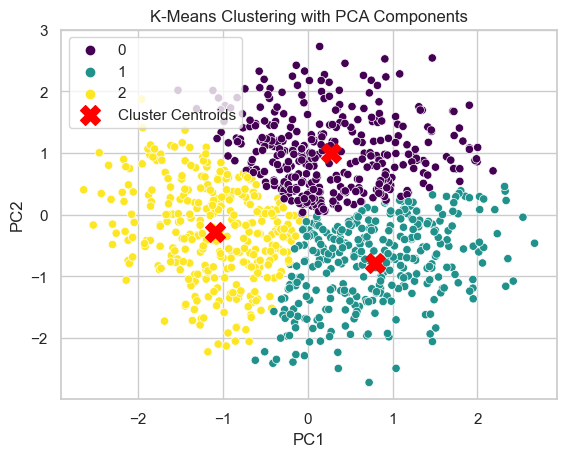

In [156]:
# Extracting the relevant features for k-means clustering
pca_features = ['PC1', 'PC2']

# Separating features
X_pca_features = pca_df[pca_features]

# Choosing a suboptimal k for demonstration purposes
k = 3

# Performing k-means clustering
kmeans_pca = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans_pca.fit(X_pca_features)

# Assigning cluster labels to the PCA DataFrame
pca_df['Cluster_KMeans'] = kmeans_pca.labels_

# Displaying the DataFrame with PCA components, original cluster labels, and new k-means cluster labels
print(pca_df.head())

# Checking centroid values of each k-means cluster by averaging the PCA features
centroid_df = pca_df.groupby('Cluster_KMeans')[['PC1', 'PC2']].mean()
print(centroid_df)

# Visualization (optional)
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x='PC1', y='PC2', hue='Cluster_KMeans', data=pca_df, palette='viridis')
plt.scatter(centroid_df['PC1'], centroid_df['PC2'], marker='X', s=200, color='red', label='Cluster Centroids')
plt.title('K-Means Clustering with PCA Components')
plt.legend()
plt.show()

***
- The first table contains:

    - PC1 and PC2: Transformed coordinates of the data points in the new feature space (possibly obtained through PCA).

    - Cluster: Cluster assignment of each data point, possibly obtained through some clustering algorithm.

    - Cluster_KMeans: Another clustering result, specifically labeled as K-means clustering.

- The second table shows the mean values of PC1 and PC2 for each cluster obtained from K-means clustering.

Explanation:

The first table indicates the coordinates of each data point after dimensionality reduction and its cluster assignments obtained from two different clustering methods: one unspecified method and K-means clustering.

The second table provides the mean values of PC1 and PC2 for each cluster identified by K-means clustering.

Interpretation:

The first table gives a snapshot of the data points in the reduced feature space along with their cluster assignments from two different clustering methods.
The second table provides additional insight into the characteristics of the clusters identified by K-means, showing the average values of PC1 and PC2 for each cluster.

This information helps in understanding the distribution of data points in the reduced feature space and the characteristics of clusters identified by different clustering methods.
***

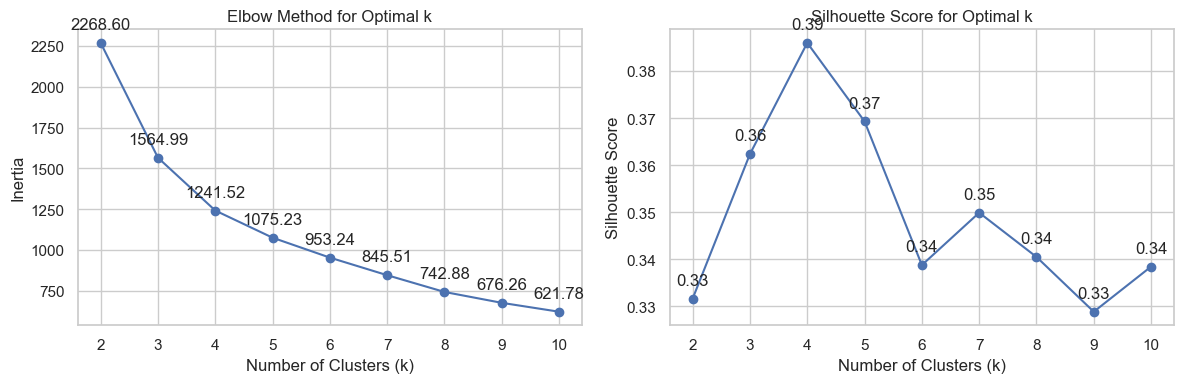

In [157]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Create a copy of the DataFrame
kMeans_studentPerformancePCA_df = pca_df.copy()

# Elbow Method for Inertia
inertias = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(kMeans_studentPerformancePCA_df)
    inertias.append(kmeans.inertia_)

# Silhouette Coefficient
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(kMeans_studentPerformancePCA_df)
    silhouette_avg = silhouette_score(kMeans_studentPerformancePCA_df, labels)
    silhouette_scores.append(silhouette_avg)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot Elbow curve
axes[0].plot(k_values, inertias, marker='o')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method for Optimal k')
# Display inertia scores
for i, txt in enumerate(inertias):
    axes[0].annotate(f"{txt:.2f}", (k_values[i], inertias[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Plot Silhouette scores
axes[1].plot(k_values, silhouette_scores, marker='o')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score for Optimal k')
# Display silhouette scores
for i, txt in enumerate(silhouette_scores):
    axes[1].annotate(f"{txt:.2f}", (k_values[i], silhouette_scores[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()


In [158]:
# Perform k-means clustering with a optimal k
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans.fit(kMeans_studentPerformancePCA_df)
cluster = kmeans.labels_
print(cluster)

# Each row in our dataset represents a student, therefore each row is assigned a label
studentPerformanceDropped_df["Cluster"] = cluster
studentPerformanceDropped_df.head(10)

# Checking centroid values of each cluster by averaging the features
studentPerformanceDropped_df.groupby('Cluster').mean()

[1 0 1 2 0 0 0 1 0 1 1 1 0 2 1 0 0 0 0 1 0 2 0 1 2 0 2 2 1 0 0 0 1 0 2 1 1
 2 0 2 0 1 2 2 2 2 0 0 2 2 0 1 1 0 2 0 1 0 2 1 1 0 0 1 0 1 0 0 0 1 1 0 1 1
 0 0 1 2 0 0 2 0 2 1 0 0 0 1 0 1 1 0 0 1 0 2 1 0 0 0 0 2 0 0 2 0 0 2 1 2 1
 2 1 1 2 1 1 2 1 1 0 1 0 1 0 1 1 0 1 0 2 0 2 2 2 0 1 1 1 2 0 1 0 0 1 1 0 0
 1 0 0 2 0 0 1 1 2 0 2 1 2 1 0 0 2 0 0 0 0 2 2 0 2 0 2 2 0 1 2 2 2 2 0 2 2
 1 0 1 0 1 0 0 0 0 1 0 1 0 0 0 2 2 1 2 1 2 0 2 1 1 2 2 0 0 0 2 2 0 0 0 0 0
 2 0 1 1 1 1 0 2 2 0 2 1 2 1 1 0 0 0 0 2 0 1 2 0 2 1 0 2 0 1 2 0 0 2 1 1 1
 2 2 2 0 1 0 2 2 1 1 1 0 0 1 2 1 2 2 0 0 0 0 2 0 0 0 1 2 0 2 0 1 2 2 0 2 0
 1 1 0 1 0 2 0 1 0 2 1 0 2 0 0 0 2 1 2 2 2 0 2 1 1 0 2 0 1 1 2 1 2 2 0 1 1
 0 2 0 0 1 0 2 2 2 1 0 2 0 2 0 0 1 0 0 2 1 1 1 1 2 2 0 1 1 2 0 1 0 0 1 2 0
 1 1 2 1 0 0 0 1 0 1 0 1 1 1 2 2 0 2 0 0 2 2 0 1 2 2 2 2 2 2 2 2 1 1 1 2 0
 1 0 2 2 2 2 0 1 0 1 2 2 0 1 1 0 1 2 0 2 1 2 2 0 0 2 0 1 2 0 2 1 1 1 2 0 2
 0 1 1 2 1 2 0 2 0 1 1 2 1 0 1 0 2 2 2 0 0 2 0 2 2 2 0 2 1 0 1 0 1 2 1 1 1
 2 0 2 2 2 1 2 2 0 0 1 2 

Gender        Age  English_Score  Math_Score  Science_Score
Cluster                                                               
0        3.461318  14.088825      78.994485   68.290219      84.091691
1        3.442073  15.935976      83.002732   76.230459      65.518293
2        3.427245  14.941176      65.930734   86.142197      79.046440

### Visualizing the optimized and dimension reduced clusters

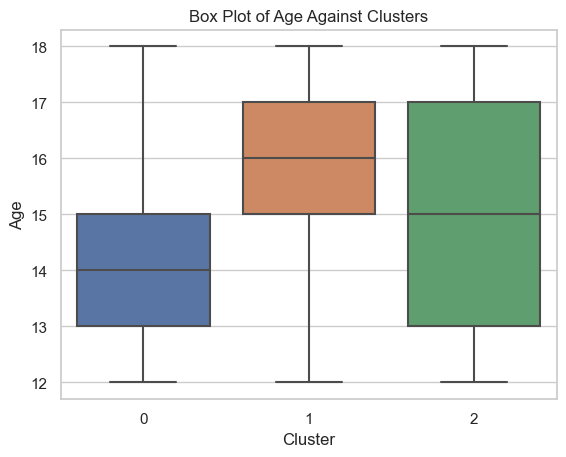

In [159]:
# Plotting box plots for age against clusters
sns.boxplot(x='Cluster', y='Age', data=studentPerformanceDropped_df)
plt.title('Box Plot of Age Against Clusters')
plt.xlabel('Cluster')
plt.ylabel('Age')
plt.show()

***
From this graph, we can see that cluster 0 has the majority of students between age 13-15, cluster 1 has a majority of students who are between age 15 and 17, cluster 2 having a wide range of age 13-17.
***

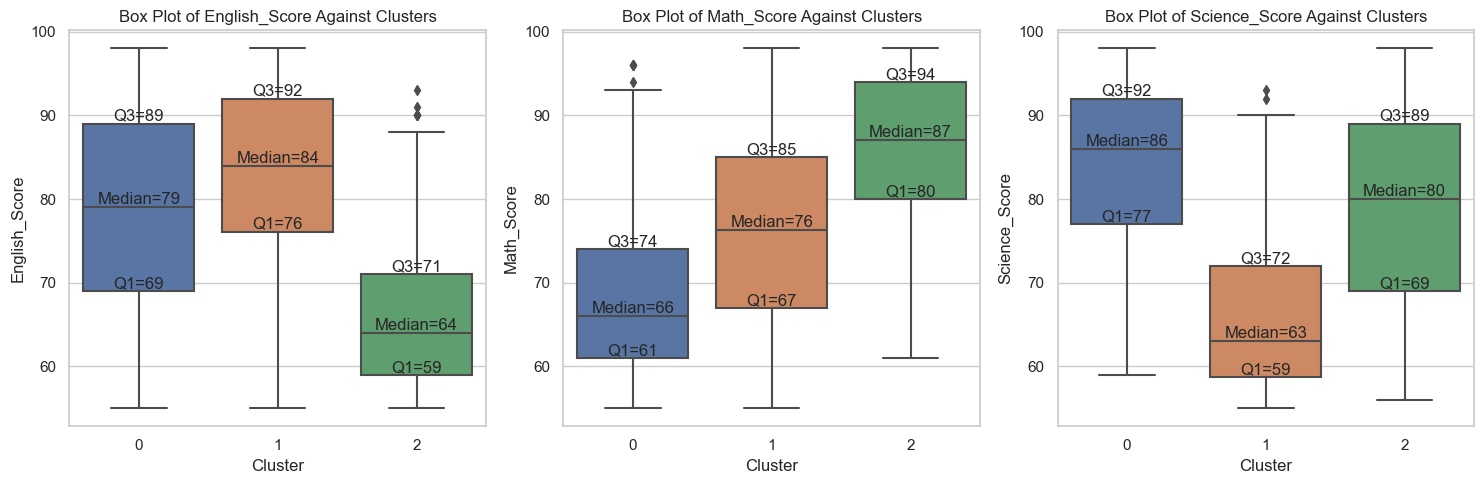

In [160]:
# Define the list of score columns
score_columns = ['English_Score', 'Math_Score', 'Science_Score']

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=len(score_columns), figsize=(15, 5))

# Plot box plots for each score column against clusters
for i, score_column in enumerate(score_columns):
    sns.boxplot(x='Cluster', y=score_column, data=studentPerformanceDropped_df, ax=axes[i])
    axes[i].set_title(f'Box Plot of {score_column} Against Clusters')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(score_column)
    
    # Calculate quartiles and median
    q1 = studentPerformanceDropped_df.groupby('Cluster')[score_column].quantile(0.25)
    q3 = studentPerformanceDropped_df.groupby('Cluster')[score_column].quantile(0.75)
    median = studentPerformanceDropped_df.groupby('Cluster')[score_column].median()
    
    # Annotate boxplot with quartiles and median
    for j in range(len(q1)):
        axes[i].text(j, q1.iloc[j], f'Q1={q1.iloc[j]:.0f}', ha='center', va='bottom')
        axes[i].text(j, q3.iloc[j], f'Q3={q3.iloc[j]:.0f}', ha='center', va='bottom')
        axes[i].text(j, median.iloc[j], f'Median={median.iloc[j]:.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

***
From this graph, we can see that:
- cluster 0 
    - Majority of students who scored better for science of score between 78 and 92 while having the majority of students also scoring the worst for math when compared to other clusters.
- cluster 1
    - Majority of students scored better for english of score between 78 and 92 while also having the majority scoring the worst for science of score between 58 and 72.
- cluster 2
    - Majority of students scored better for maths with the score between 80 and 94 while also having the majority at being the worst at enlgish scoring between 58 and 72.
***

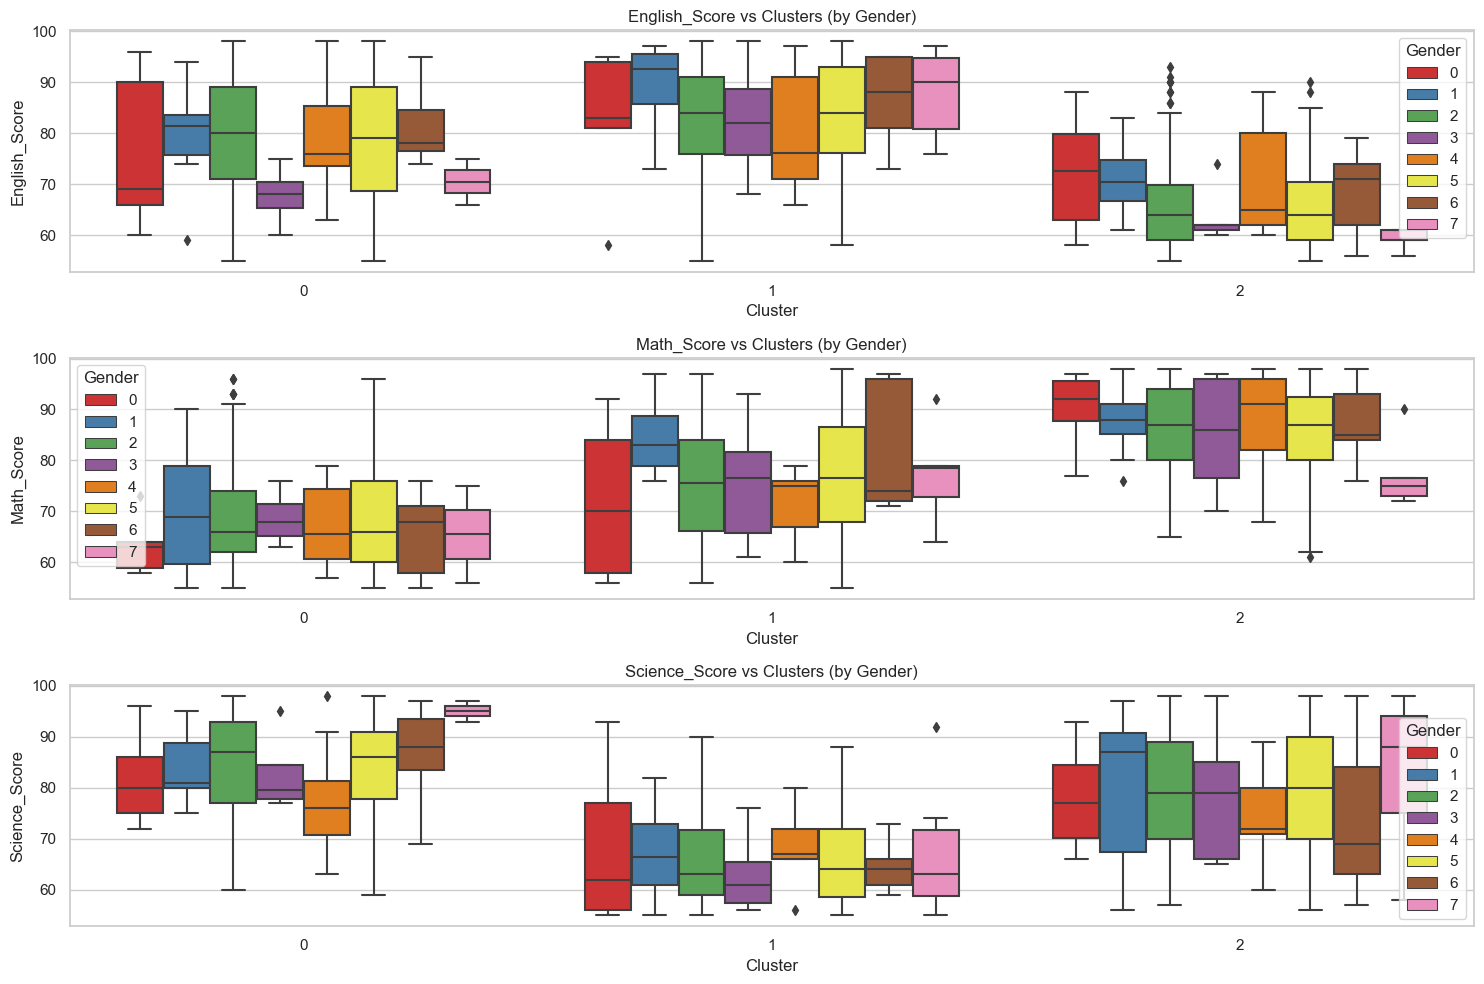

In [161]:
score_columns = ['English_Score', 'Math_Score', 'Science_Score']
plt.figure(figsize=(15, 10))

for i, column in enumerate(score_columns, 1):
    plt.subplot(3, 1, i)
    sns.boxplot(x='Cluster', y=column, hue='Gender', data=studentPerformanceDropped_df, palette='Set1')
    plt.title(f'{column} vs Clusters (by Gender)')
    plt.xlabel('Cluster')
    plt.ylabel(column)
    plt.legend(title='Gender')

plt.tight_layout()
plt.show()

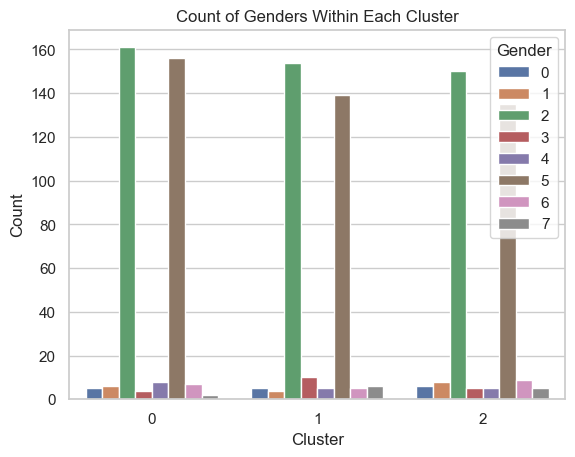

In [162]:
# Plot count of genders within each cluster
sns.countplot(x='Cluster', hue='Gender', data=studentPerformanceDropped_df)
plt.title('Count of Genders Within Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.show()

***
From this graph, we can see that the majority of clusters 0,1,2 are dominated by male and female students with the other genders being the least. However, males still form a majority of the population in the clusters.

***
After dimension reduction:

Based on the cluster characteristics provided, we can describe the characteristics of each cluster as follows:

Cluster 0: 
- Mix of males and females
- Age range of 13-15
- English score of 69-89 with a median of 79
- Math score of 61-74 with a median of 66
- Science score of 77-92 with a median of 86

Cluster 1: 
- Mix of males and females
- Age range of 15-17 
- English score of 76-92 with a median of 84
- Math score of 67-85 with a median of 76
- Science score of 59-72 with a median of 63

Cluster 2: 
- Mix of males and females
- Age range of 13-17
- English score of 59-71 with a median of 64
- Math score of 80-94 with a median of 87
- Science score of 69-89 with a median of 80
***

### GMM (Gaussian mixture model) clustering

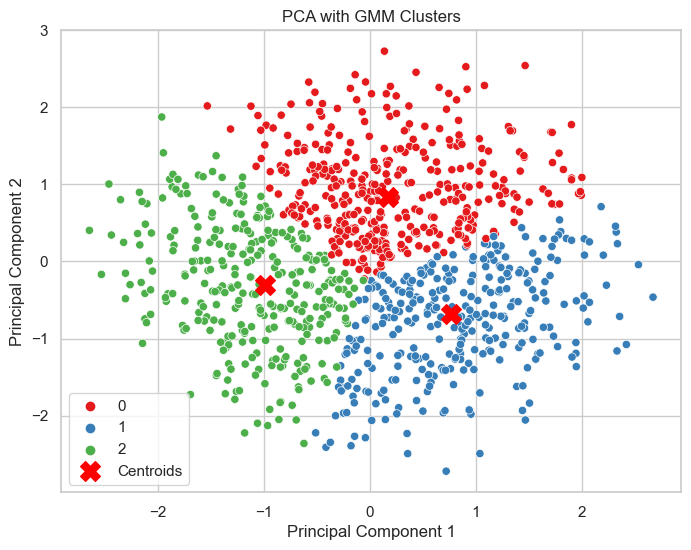

           Gender        Age  English_Score  Math_Score  Science_Score
Cluster                                                               
0        3.426630  14.111413      78.650148   69.002574      83.940217
1        3.489028  15.902821      83.566791   76.084419      65.338558
2        3.418530  15.028754      65.458587   86.252171      78.712460


In [172]:
studentPerformanceGMM_df = studentPerformanceScaled_df.copy()

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(studentPerformanceGMM_df.drop(columns=['Gender']))

# Perform GMM
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(pca_result)
clusters = gmm.predict(pca_result)

studentPerformanceDropped_df['Cluster'] = clusters

# Get centroids of clusters
centroids = gmm.means_

# Visualize the clusters with centroids
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=studentPerformanceDropped_df['Cluster'], palette='Set1')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, color='red', label='Centroids')
plt.title('PCA with GMM Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# Analyze the clusters
cluster_analysis = studentPerformanceDropped_df.groupby('Cluster').mean()
print(cluster_analysis)

### Visualisations of GMM clusterings

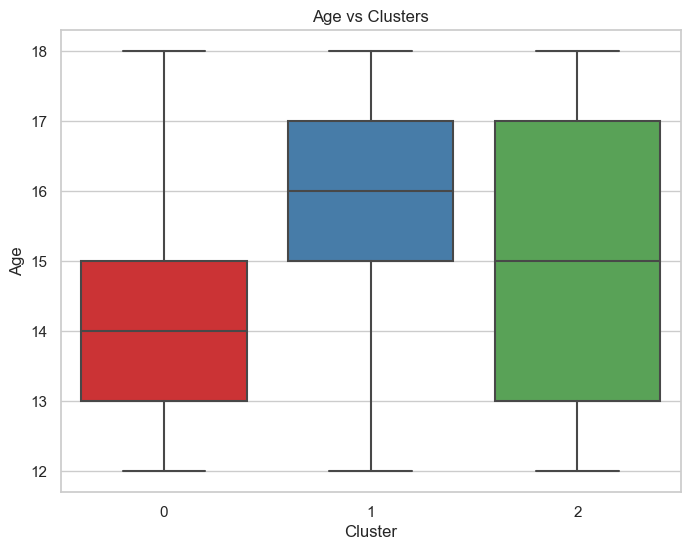

In [164]:
# Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Cluster', y='Age', data=studentPerformanceDropped_df, palette='Set1')
plt.title('Age vs Clusters')
plt.xlabel('Cluster')
plt.ylabel('Age')
plt.show()

***
We can see that:
- cluster 0 has majority of students from age 13 to age 15. This shows that students in this cluster are on the younger side.
- cluster 1 has majority of students from age 15 to age 17. This shows that students in this cluster are on the older side.
- cluster 2 has majority of students from age 13 to age 17. This shows that students in this cluster are a mix of younger and older students.
***

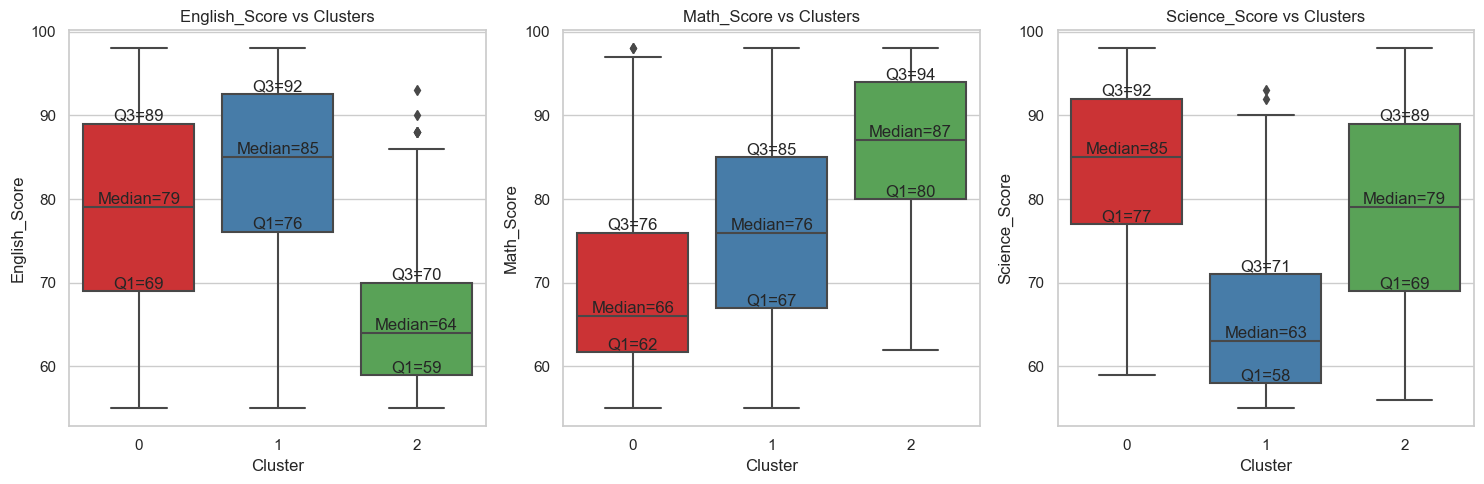

In [165]:
score_columns = ['English_Score', 'Math_Score', 'Science_Score']
plt.figure(figsize=(15, 5))

for i, column in enumerate(score_columns, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='Cluster', y=column, data=studentPerformanceDropped_df, palette='Set1')
    
    # Calculate quartiles and median
    q1 = studentPerformanceDropped_df.groupby('Cluster')[column].quantile(0.25)
    q3 = studentPerformanceDropped_df.groupby('Cluster')[column].quantile(0.75)
    median = studentPerformanceDropped_df.groupby('Cluster')[column].median()
    
    # Annotate boxplot with quartiles and median
    for j in range(len(q1)):
        plt.text(j, q1.iloc[j], f'Q1={q1.iloc[j]:.0f}', ha='center', va='bottom')
        plt.text(j, q3.iloc[j], f'Q3={q3.iloc[j]:.0f}', ha='center', va='bottom')
        plt.text(j, median.iloc[j], f'Median={median.iloc[j]:.0f}', ha='center', va='bottom')
    
    plt.title(f'{column} vs Clusters')
    plt.xlabel('Cluster')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

***
We can see that:
- Cluster 0 has students with the lowest math score but the highest science score.
- Cluster 1 has students with the lowest science score but highest english score.
- Cluster 2 has students with the lowest english score but highest math score.

From this, we can observe that each cluster has a similar characteristic which is the specific subject that they are either good or bad at.
***

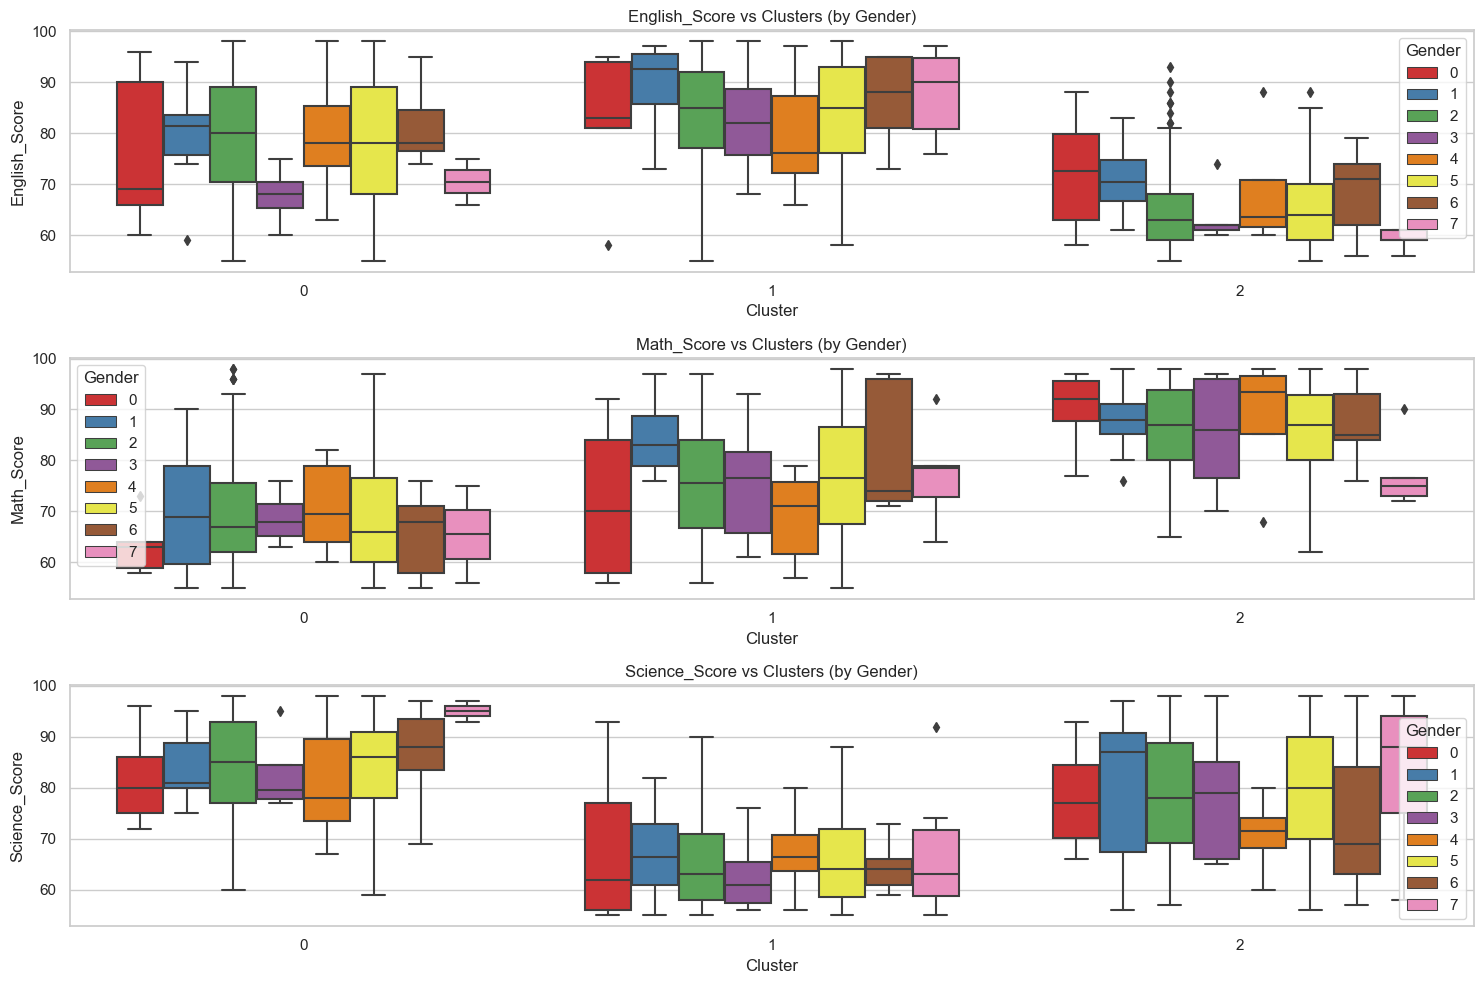

In [166]:
score_columns = ['English_Score', 'Math_Score', 'Science_Score']
plt.figure(figsize=(15, 10))

for i, column in enumerate(score_columns, 1):
    plt.subplot(3, 1, i)
    sns.boxplot(x='Cluster', y=column, hue='Gender', data=studentPerformanceDropped_df, palette='Set1')
    plt.title(f'{column} vs Clusters (by Gender)')
    plt.xlabel('Cluster')
    plt.ylabel(column)
    plt.legend(title='Gender')

plt.tight_layout()
plt.show()

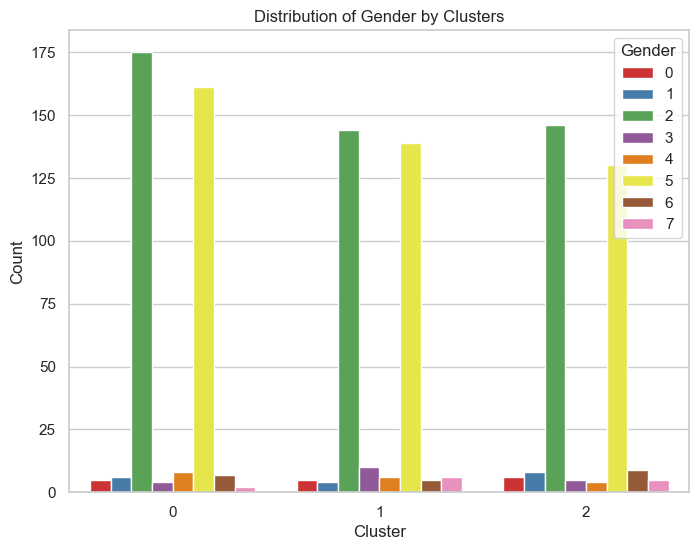

In [167]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Cluster', hue='Gender', data=studentPerformanceDropped_df, palette='Set1')
plt.title('Distribution of Gender by Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.show()

***
After dimension reduction:

Based on the cluster characteristics provided, we can describe the characteristics of each cluster as follows:

Cluster 0: 
- Mix of males and females
- Age range of 13-15
- English score of 69-89 with a median of 79
- Math score of 62-76 with a median of 66
- Science score of 77-92 with a median of 85

Cluster 1: 
- Mix of males and females
- Age range of 15-17 
- English score of 76-92 with a median of 85
- Math score of 67-85 with a median of 76
- Science score of 58-71 with a median of 63

Cluster 2: 
- Mix of males and females
- Age range of 13-17
- English score of 59-70 with a median of 64
- Math score of 80-94 with a median of 87
- Science score of 69-89 with a median of 79
***

## All models clusters interpretation:
***
K-Clusters after dimension reduction and finiding optimal k clusters to use:

Based on the cluster characteristics provided, we can describe the characteristics of each cluster as follows:

Cluster 0: 
- Mix of males and females
- Age range of 13-15
- English score of 69-89 with a median of 79
- Math score of 61-74 with a median of 66
- Science score of 77-92 with a median of 86

Cluster 1: 
- Mix of males and females
- Age range of 15-17 
- English score of 76-92 with a median of 84
- Math score of 67-85 with a median of 76
- Science score of 59-72 with a median of 63

Cluster 2: 
- Mix of males and females
- Age range of 13-17
- English score of 59-71 with a median of 64
- Math score of 80-94 with a median of 87
- Science score of 69-89 with a median of 80

***

GNN clustering after dimension reduction and using the optimal k clusters:

Based on the cluster characteristics provided, we can describe the characteristics of each cluster as follows:

Cluster 0: 
- Mix of males and females
- Age range of 13-15
- English score of 69-89 with a median of 79
- Math score of 62-76 with a median of 66
- Science score of 77-92 with a median of 85

Cluster 1: 
- Mix of males and females
- Age range of 15-17 
- English score of 76-92 with a median of 85
- Math score of 67-85 with a median of 76
- Science score of 58-71 with a median of 63

Cluster 2: 
- Mix of males and females
- Age range of 13-17
- English score of 59-70 with a median of 64
- Math score of 80-94 with a median of 87
- Science score of 69-89 with a median of 79

***
Evaluating the clusters characteristics obtained from K-clustering and GMM clustering:

- K-Clustering:
    
    - Cluster 0: 
        - This cluster still exhibits a slightly higher average gender encoding compared to the other clusters, indicating a potential imbalance in gender representation with a mix of males and females. The average age is approximately 14 years old. In terms of academic performance, students in this cluster have relatively high scores in English and Science compared to their Math scores. This suggests that students in this cluster may excel in language and science subjects but may struggle relatively in mathematics.

    - Cluster 1: 
        - Students in this cluster have a slightly higher average age compared to Cluster 0 of around 16. The gender encoding is around the same. In terms of academic performance, this cluster has the highest average scores in English, followed by Math and then Science. This indicates that students in this cluster perform well overall but may have a stronger performance in English compared to other subjects.

    - Cluster 2: 
        - This cluster has a similar average gender encoding to Cluster 1 and a slightly lower average age than cluster 1. In terms of academic performance, students in this cluster have the highest average scores in Math, followed by Science and then English. This suggests that students in this cluster excel in mathematics and science subjects but may have a relatively lower performance in English.

    - Some characteristics we can take note of:
        - There is a mix of males and females who are good and bad in every subject.
        - Students in cluster 0 tend to be younger compared to those in other clusters.
        - Students in cluster 2 have lower Science scores but higher English scores compared to those in other clusters.
        - Each cluster has a clear indicator of whichever subjects they excel at, of around 80+ score, and whichever subject they clearly do badly at, of around 60+ score. 

- GNN clustering:

    - Cluster 0: 
        -   This cluster has a average gender encoding of 3.4, indicating a potential mix of multiple genders such as male(5) and female(2) and others. The average age is around 14 years old. In terms of academic performance, students in this cluster have relatively high English and Science scores compared to their Math scores. This cluster might represent students who excel in language and science subjects but struggle relatively in mathematics.

    - Cluster 1: 
        -   Students in this cluster have a slightly higher average age compared to Cluster 0 and 2, indicating that they might be slightly older than the rest of the clusters. The gender encoding is slightly larger than cluster 0 indicating a greater number of males(5) in the group. In terms of academic performance, this cluster has the highest average scores in English, followed by Math and then Science. This cluster might represent students who perform well overall for English but suffer greatly for subjects such as maths and science.

    - Cluster 2: 
        -   This cluster has a similar average gender encoding to Cluster 0 but a slightly higher average age. In terms of academic performance, students in this cluster have the highest average scores in Math, followed by Science and then English. This cluster might represent students who excel in mathematics and science subjects but have a relatively lower performance in English.



As for which cluster of students needs more attention, it depends on the specific context and goals of our attention. 
- Age Range: Cluster 1 has the highest age range (15-17), which may indicate that these students are approaching important stages such as college applications or entering the workforce.

- Academic Performance: 
    - If we consider English scores as a primary factor, Cluster 2 might need more attention as they have the lowest average English score among all clusters.
    - If we consider Math scores as a primary factor, Cluster 0 might need more attention as they have the lowest average Math score among all clusters.
    - If we consider Science scores as a primary factor, Cluster 1 might need more attention as they have the lowest average Science score among all clusters.  
    - If the goal is to balance the performance across all subjects, then attention might be needed for clusters showing a significant disparity between subjects. For example, Cluster 0 excels in Science but has slightly lower scores in Math and Science, so efforts could be made to improve their performance in these areas.  

***

## Conclusion

To conclude, I have successfully made a clustering model, with a Silhouette Score of 0.36.

With clustering, we have succesfully grouped the students into multiple clusters so that we can cater needs for different students.

I resulted in having clusters 3 in total.

My clusters are a mix of female or male with the other genders taking a minority each time due to the small number of them. All my clusters have similar characteristics such as being good or bad at certain subjects. Apart from cluster 2, all other clusters have similar age groups such as being either older or younger, with cluster 2 being a mix of both age groups.

Of all clusters, the cluster I would like to focus on the most are clusters 0. Considering the above analysis, Cluster 0 appears to require more attention due to the lower median scores in English and Math, as well as the younger age range, which presents an opportunity for early intervention to address any academic challenges before they progress further in their education.

After cluster 0, the next important cluster is cluster 1. This might be because they comprises older students and likely nearing the end of high school or preparing for higher education or the workforce. Interventions for this cluster may focus on strengthening mathematical skills to ensure readiness for college or career paths that require strong quantitative abilities.

After Cluster 1, the next is cluster 2. Cluster 2 is the least important as they are spanning a wider age range, they are covering both early and late high school years. They only require help to ensure well-rounded academic proficiency across all subjects which means that they are able to cope well.